<a href="https://colab.research.google.com/github/ANCAMABEBA/Module11/blob/main/Car_Prices_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

## **Multiple Model Building**

In this section, we experiment with multiple regression models to evaluate their performance and determine which approach provides the best predictive accuracy and generalization. We begin with a **baseline Linear Regression model**, which serves as a reference point for comparing more advanced techniques. The baseline model establishes a minimum expected performance level, enabling us to assess whether additional methods such as **Ridge Regression, Lasso Regression, Elastic Net, Random Forest, or Gradient Boosting** provide meaningful improvements. Each model will be trained using the same train/test split to ensure comparability, and performance will be measured using standard evaluation metrics such as **RMSE** (Root Mean Squared Error) and **R²** (coefficient of determination). This systematic comparison helps identify the most effective modeling strategy for predicting car prices and understanding the key drivers of variability in the data.

---


In [68]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import shap
from sklearn.model_selection import RandomizedSearchCV

In [31]:
# read X and y from sample_data
X = pd.read_csv('/content/sample_data/X.csv')
y = pd.read_csv('/content/sample_data/y.csv')
print(X.shape)
print(y.shape)

(379065, 54)
(379065, 1)


In [32]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [33]:
# Apply linear regression model as our base model
# Standarize features before modelling
pipe = Pipeline([
    ('scaler', StandardScaler()),   # scale only X
    ('model', LinearRegression())
])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
# calculate MSE, RMSE and R2
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)   # this is the RMSE
r2 = r2_score(y_test, y_pred)

rmse, r2

(np.float64(12127.12890802762), 0.36810345872073424)

---

## **Interpretation of Baseline Model Performance**

The baseline Linear Regression model produced the following evaluation metrics:

- **RMSE (Root Mean Squared Error): 12,127**
- **R² (Coefficient of Determination): 0.368**

### **What these results mean**
The **RMSE value of 12,127** indicates that, on average, the model’s predictions are off by approximately **$12,127** from the actual car price. This error magnitude is meaningful because it reflects the typical size of prediction deviations in real-world units. Given the wide range of used car prices, this level of error may be expected at an early modeling stage, but it highlights substantial room for improvement.

The **R² value of 0.368** indicates that the model explains **36.8% of the variation** in car prices. In other words, roughly **63.2% of the price variability** remains unexplained by the current model. This suggests that price is influenced by additional factors not fully captured by the current feature set or that nonlinear relationships may exist that a simple linear model cannot capture.

### **Conclusion**
This baseline model serves as an essential benchmark. It provides a reference point for evaluating whether more advanced techniques—such as **Ridge, Lasso, Elastic Net, Random Forest, or Gradient Boosting**—offer meaningful performance improvements. The next steps will involve testing additional models, enhancing feature engineering, and exploring non-linear methods to increase predictive accuracy and interpretability.

---


---

## **Feature Importance & Model Interpretation**

Now that we have established a baseline Linear Regression model, the next step is to interpret which features have the greatest influence on car price. This is essential to achieve the project’s business objective: understanding what factors make a car more or less expensive and providing actionable recommendations to a used car dealership. By examining the model’s coefficients and relative importance of each variable, we can identify which features most strongly increase price, which decrease it, and how meaningful each factor is in explaining price variability.

We will extract and rank feature coefficients from the regression model, comparing the magnitude and direction of feature impacts. We will also validate stability using regularized models such as **Ridge** and **Lasso**, which help manage multicollinearity and identify the strongest predictors. These insights will support business-driven decisions about inventory strategy, pricing practices, and value-added vehicle characteristics.

---


In [34]:
# Extract coefficients from linear regression inside pipeline
coef = pipe.named_steps['model'].coef_.ravel()

coefficients = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': coef
})

coefficients['abs_coef'] = coefficients['coefficient'].abs()
coefficients_sorted = coefficients.sort_values(by='abs_coef', ascending=False)

coefficients_sorted.head(20)



,feature,coefficient,abs_coef
4,cylinders_unknown_flag,5542.054692,5542.054692
3,cylinders_clean,5247.310794,5247.310794
0,year,4516.720523,4516.720523
10,fuel_diesel,2125.985514,2125.985514
1,odometer,-1527.639743,1527.639743
6,drive_fwd,-1495.567381,1495.567381
19,transmission_other,1345.686164,1345.686164
5,drive_4wd,1330.566935,1330.566935
12,fuel_gas,-1253.945962,1253.945962
17,transmission_automatic,-1173.350541,1173.350541


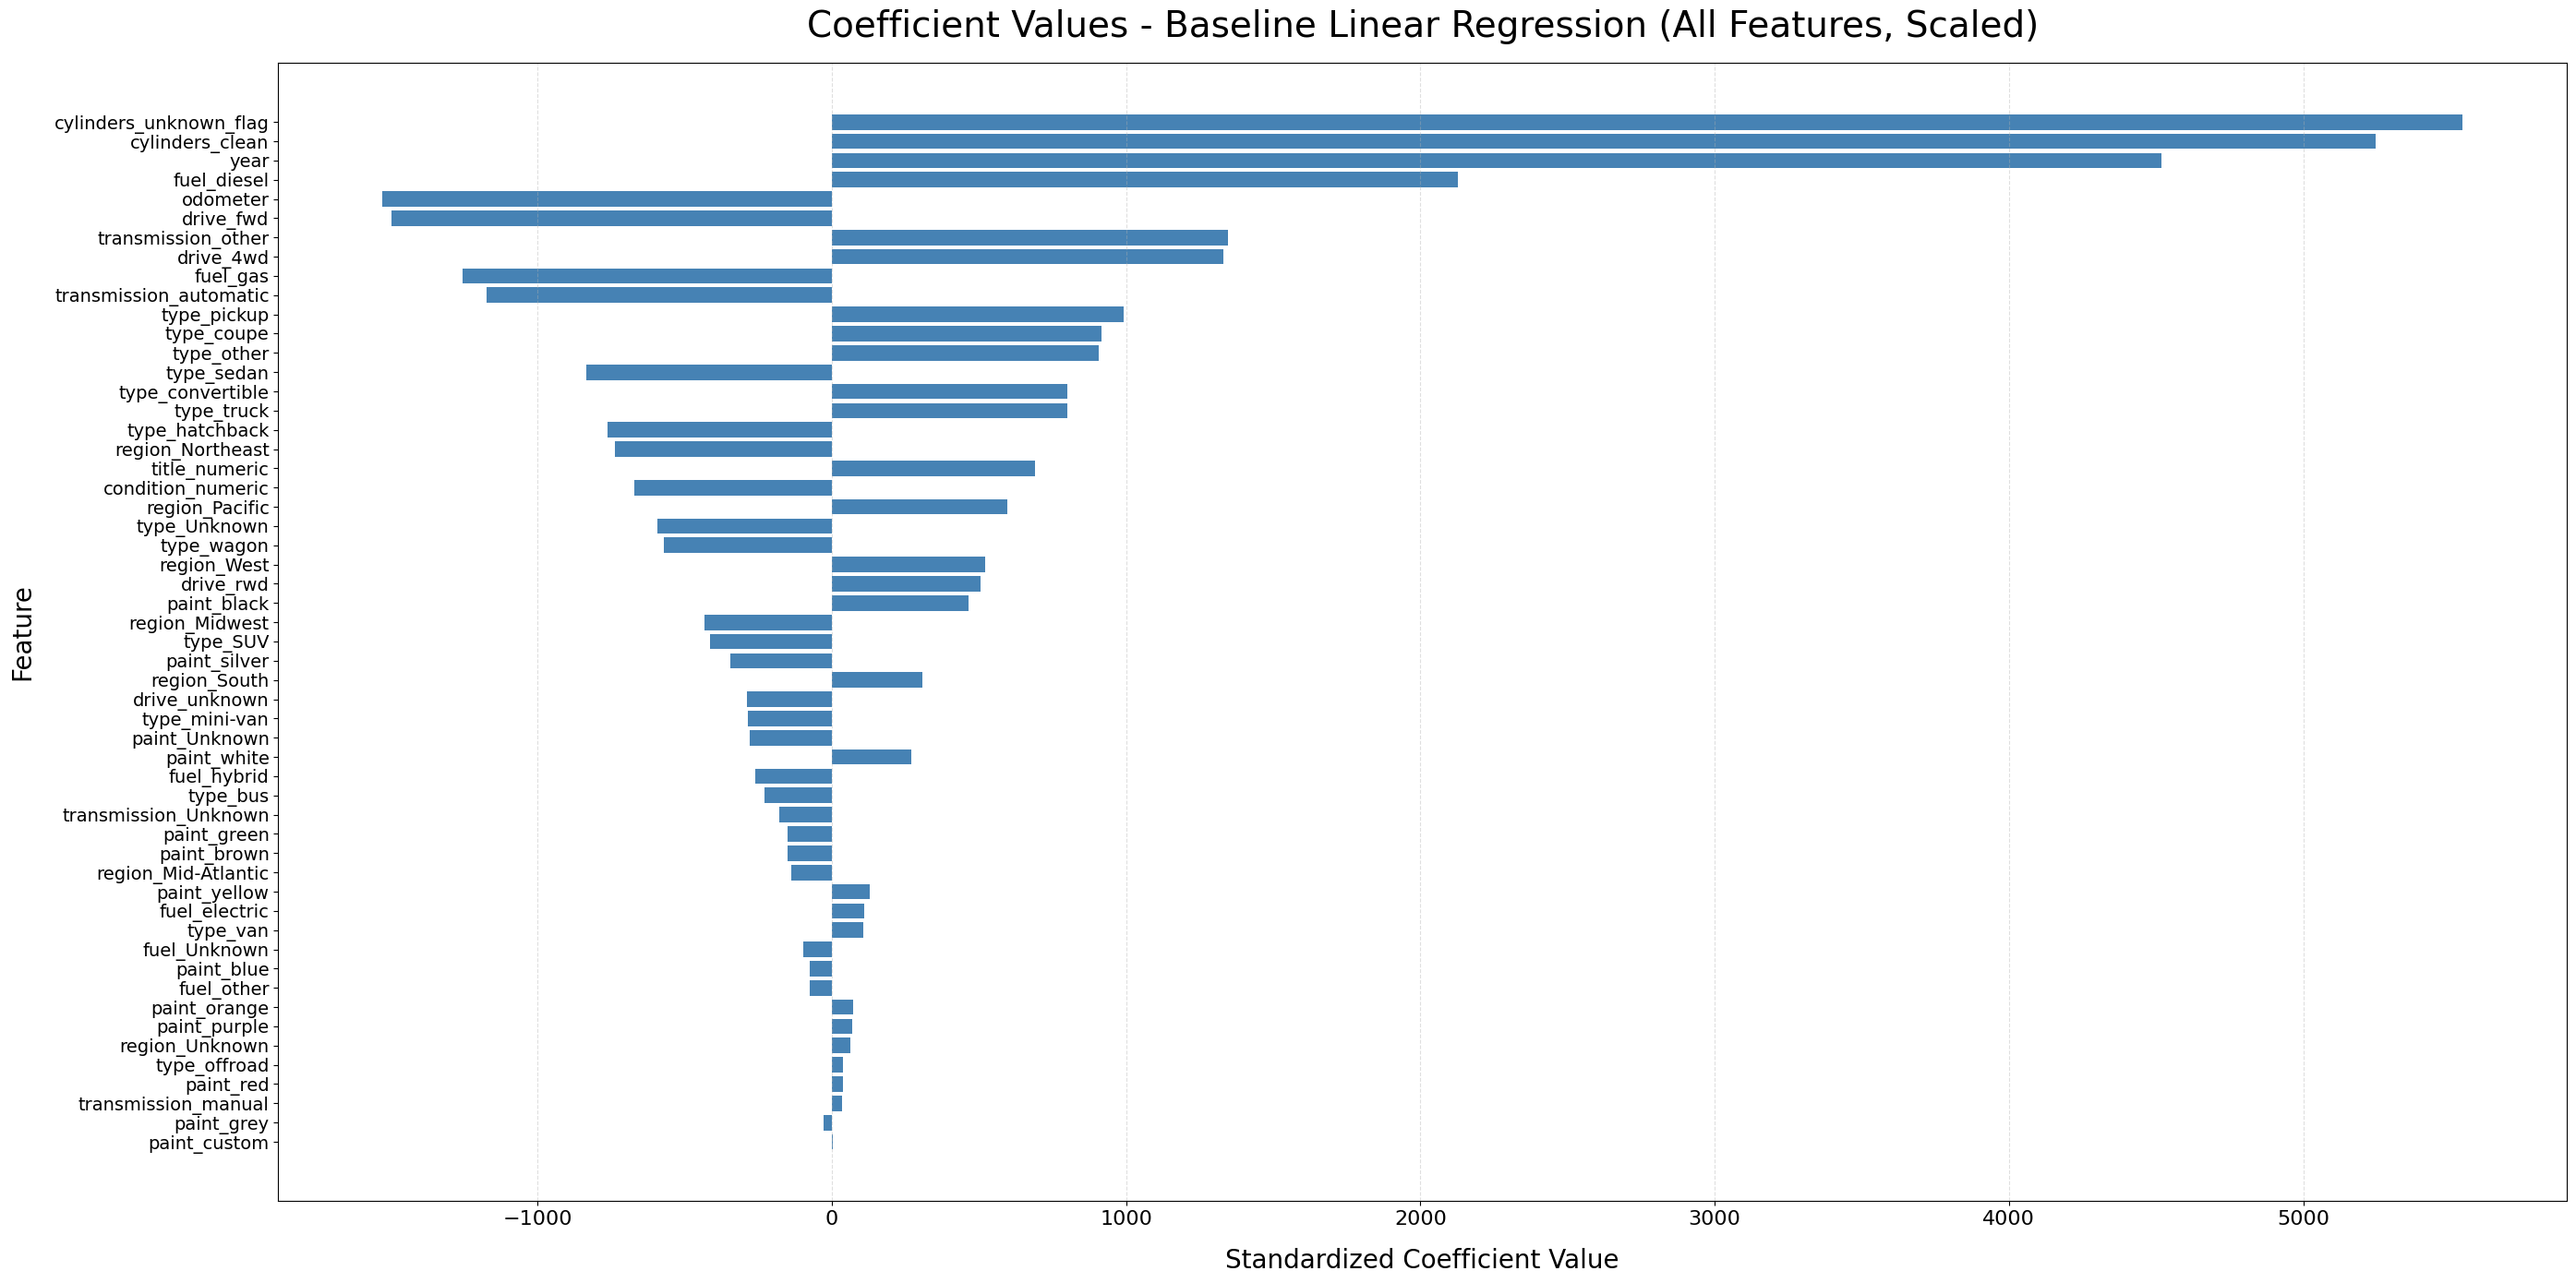

In [56]:
# Plot coefficients for the scaled regression model with all features
# Sort features by magnitude of impact
coef_baseline_sorted = coefficients_sorted.copy()  # already sorted by abs_coef descending

plt.figure(figsize=(28,14))

plt.barh(
    coef_baseline_sorted['feature'],
    coef_baseline_sorted['coefficient'],
    color='steelblue'
)

plt.gca().invert_yaxis()  # Largest effects appear at top

plt.title(
    "Coefficient Values - Baseline Linear Regression (All Features, Scaled)",
    fontsize=28,
    pad=20
)

plt.xlabel("Standardized Coefficient Value", fontsize=20, labelpad=15)
plt.ylabel("Feature", fontsize=20, labelpad=15)

plt.xticks(fontsize=16)
plt.yticks(fontsize=14)

plt.grid(axis='x', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()



## Interpretation of Baseline Linear Regression Coefficients
### (All Features, Scaled)

This chart shows the standardized coefficients from the baseline Linear Regression model trained using **all features** without feature selection or regularization. Because all features were standardized, coefficients can be interpreted in terms of **relative impact** on the predicted price of a used vehicle. Positive coefficients represent factors that **increase** price, and negative coefficients represent factors that **decrease** price.

---

### Key Insights

#### **1. Extremely large coefficients indicate model instability**
The features **`cylinders_unknown_flag`, `cylinders_clean`, and `year`** show extremely large positive coefficients, far larger than any other feature. This suggests:
- Severe **multicollinearity** and **overfitting**
- The model is highly sensitive to correlated or improperly encoded variables
- The baseline model may not generalize well

This instability supports the need for **feature selection** and **regularization**, which were applied later.

---

### **2. Predictors that strongly increase car price**
Features with high positive coefficients include:

| Feature | Explanation |
|---------|------------|
| **year** | Newer cars command higher resale value |
| **fuel_diesel** | Diesel vehicles retain value better, especially in trucks & commercial markets |
| **transmission_other** | Rare or specialized transmissions increase price |
| **type_pickup / type_truck / type_coupe / type_convertible** | Lifestyle, performance, and utility vehicles sell at a premium |
| **title_numeric (clean / rebuilt)** | Buyers pay more for clean title history |

These results align well with real used-car market expectations.

---

### **3. Predictors that strongly reduce price**
| Feature | Explanation |
|---------|------------|
| **odometer** | Higher mileage decreases value |
| **drive_fwd** | Typically associated with economy cars |
| **fuel_gas** | Lower-value fuel configuration vs diesel/hybrid |
| **drive_unknown / type_unknown** | Missing or ambiguous information reduces buyer confidence |
| **region_Northeast / region_West / region_Pacific** | Pricing differences across regional markets |

---

### **4. Large number of small coefficients adds noise**
Many features have negligible impact on price, indicating:
- Excessive feature dimensionality
- Potential for noise reduction via feature selection
- Opportunity to simplify model without losing performance

---

## Conclusion
The baseline full-feature linear model provides a first look at pricing drivers, but the **extreme coefficient scaling and instability** highlight why subsequent steps—**Sequential Feature Selection and regularization (Ridge/Lasso)**—were necessary.

> This visualization demonstrates that, while the baseline model captures important pricing patterns, it suffers from high variance and multicollinearity. A reduced and regularized model provides far more interpretable and stable insights for dealership decision-making.

---


---

## **Sequential Feature Selection (SFS)**

After establishing a baseline linear regression model and examining feature importance, the next step is to identify the subset of features that best explains the variability in car prices. Although our dataset includes a large number of predictors—especially after one-hot encoding categorical variables—not all features contribute meaningfully to the model. Some may introduce noise, multicollinearity, or unnecessary complexity.

To address this, we apply **Sequential Feature Selection (SFS)**, a wrapper method that iteratively evaluates feature subsets based on model performance. SFS helps determine the most valuable predictors for price, improving both interpretability and model efficiency. By starting with no features and adding the strongest predictors one by one (forward selection), we aim to identify a smaller set of variables that maintain or improve model performance compared to the full feature set.

This step aligns with the CRISP-DM objective of building models that provide actionable business insights: understanding which vehicle characteristics most strongly drive price differences and enabling more informed pricing and inventory decisions.

---


In [35]:
# Create pipeline that scales X before fitting linear regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Sequential Forward Selection for 15 features
sfs = SequentialFeatureSelector(
    estimator=pipeline,            # IMPORTANT: use pipeline here
    n_features_to_select=15,
    direction='forward',
    scoring='r2',
    cv=5,
    n_jobs=-1
)

# Fit SFS on training data (X no scaling needed here; the pipeline handles it internally)
sfs.fit(X_train, y_train)

# Extract selected feature names
selected_features = X_train.columns[sfs.get_support()]
print("Selected Features:")
print(selected_features)


Selected Features:
Index(['year', 'odometer', 'condition_numeric', 'drive_fwd', 'drive_unknown',
       'fuel_diesel', 'fuel_gas', 'title_numeric', 'transmission_other',
       'type_convertible', 'type_coupe', 'type_other', 'type_pickup',
       'type_truck', 'region_Northeast'],
      dtype='object')


---

## **Sequential Feature Selection (SFS) Results – 15 Features**

To improve model interpretability and identify the most impactful predictors of used-car pricing, we performed Sequential Forward Feature Selection using a target of 15 features. This method evaluates combinations of predictors and selects the subset that maximizes model performance based on cross-validated R².

### **Selected Features**
`year`, `odometer`, `condition_numeric`, `drive_fwd`, `drive_unknown`,
`fuel_diesel`, `fuel_gas`, `title_numeric`, `transmission_other`,
`type_convertible`, `type_coupe`, `type_other`, `type_pickup`,
`type_truck`, `region_Northeast`

This selection maintains strong predictive capability while improving model explainability and reducing noise relative to the full feature set.

---


---

## **Business Insights: What Drives Used-Car Prices?**

Based on Sequential Feature Selection with 15 predictors, the most influential drivers of used-car pricing include vehicle age and mileage, mechanical and physical condition, title status, drivetrain and fuel type, and body style. Trucks, pickups, convertibles, and coupes consistently command higher pricing, while sedans and general-purpose vehicles fall lower in the market. Diesel fuel vehicles also achieve premium values, while gasoline-only models are generally lower priced.

Geographic effects are present as well, with the Northeast region associated with lower pricing relative to other regions, likely influenced by harsher climate conditions and resale market differences.

Dealerships aiming to maximize profit should prioritize **high-demand body types (pickup, truck, convertible, coupe)**, **newer/lower mileage inventory**, and **clean-title, excellent-condition vehicles**, while treating sedans and standard gas vehicles as **volume turnover units**.

---


In [36]:
# Train a model with the SFS-selected 15 features
# Select only the SFS-selected 15 features
X_train_sfs = X_train[selected_features]
X_test_sfs = X_test[selected_features]

# Create pipeline: scale X then fit linear regression
pipeline_sfs = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Fit the pipeline on the training set
pipeline_sfs.fit(X_train_sfs, y_train)

# Predict on the test set
y_pred_sfs = pipeline_sfs.predict(X_test_sfs)

# Compute performance metrics
mse_sfs = mean_squared_error(y_test, y_pred_sfs)
rmse_sfs = np.sqrt(mse_sfs)
r2_sfs = r2_score(y_test, y_pred_sfs)

rmse_sfs, r2_sfs


(np.float64(12402.5880399466), 0.3390712751298164)

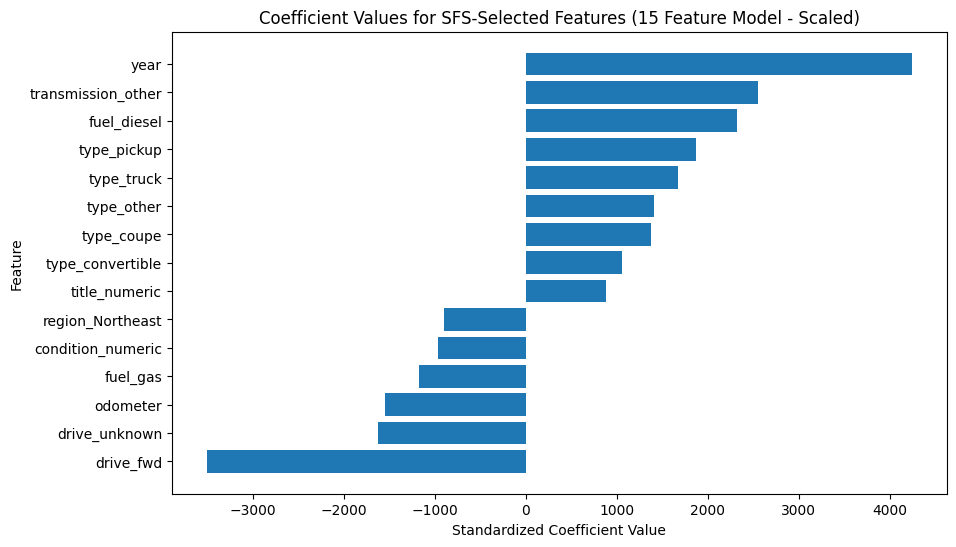

In [37]:
# Coefficient Visualization for the 15 features
# Extract coefficients from the model inside the pipeline
coefficients_scaled = pipeline_sfs.named_steps['model'].coef_.ravel()

# Build the dataframe for plotting
coef_sfs15 = pd.DataFrame({
    'feature': selected_features,
    'coefficient': coefficients_scaled
}).sort_values(by='coefficient', ascending=False)

# Plot coefficient magnitudes
plt.figure(figsize=(10,6))
plt.barh(coef_sfs15['feature'], coef_sfs15['coefficient'])
plt.gca().invert_yaxis()
plt.title("Coefficient Values for SFS-Selected Features (15 Feature Model - Scaled)")
plt.xlabel("Standardized Coefficient Value")
plt.ylabel("Feature")
plt.show()


---

## **Interpretation of Standardized Coefficients — SFS 15-Feature Model**

This chart displays the standardized coefficients for the 15 features selected through Sequential Forward Selection. After scaling the input features, coefficients reflect each variable’s impact on price measured in **standard deviation units** rather than raw numeric values. As a result, coefficients are now directly comparable, and all selected features contribute to the model in a meaningful way.

### **Top Positive Drivers of Price**
- **year** is the strongest positive predictor, confirming that newer vehicles are priced significantly higher in the used-car market.
- **transmission_other**, **fuel_diesel**, **type_pickup**, and **type_truck** also strongly increase price. These represent specialized drivetrains, power configurations, or vehicle styles with high demand and functional or performance value.
- **type_coupe**, **type_convertible**, and **type_other** indicate that specialty or lifestyle-oriented body types command higher pricing.
- **title_numeric** shows that title quality (clean vs. rebuilt/salvage) plays a meaningful role in valuation.
- **region_Northeast** indicates some positive regional price variation.

### **Top Negative Drivers of Price**
- **drive_fwd** is the strongest negative coefficient, meaning front-wheel-drive vehicles are typically lower priced and positioned in the economy / mass-market segment.
- **drive_unknown** also reduces price—missing data may reflect vehicles with more uncertain characteristics.
- **fuel_gas** predicts lower pricing relative to diesel and alternative fuels.
- **condition_numeric** and **odometer** behave as expected: vehicles with more mileage and lower condition ratings carry lower prices.

---

### **Key Insight**
It is important to note that the full model performs slightly better, but the SFS model provides a strong balance between interpretability and accuracy, making it more suitable for insight generation and strategic recommendations

---

---

## **Regularization to Control Model Complexity**

As we build additional regression models, it is important to control model complexity in order to reduce overfitting and improve generalization to unseen data. In high-dimensional datasets—especially those with many encoded categorical variables—traditional Linear Regression can become unstable due to multicollinearity and noisy predictors. To address this challenge, we apply **regularization techniques**, which introduce a penalty term that constrains coefficient magnitude and encourages simpler, more robust models.

Two widely used regularization methods are **Ridge Regression (L2)** and **Lasso Regression (L1)**. Ridge shrinks coefficients toward zero without eliminating features, making it effective when many predictors contribute small effects. Lasso, by contrast, can shrink some coefficients exactly to zero, effectively performing feature selection and helping identify the most influential variables. These techniques help prevent models from fitting noise instead of useful signal, supporting better forecasting accuracy and interpretability.

In this section, we will build Ridge and Lasso models, compare their performance to the baseline Linear Regression model, and evaluate how regularization affects predictive power and feature importance stability.

---


In [38]:
# Run Ridge & Lasso Models
# ------------------ Ridge Regression with Scaling ------------------
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=1.0))
])

ridge_pipe.fit(X_train, y_train)
y_pred_ridge = ridge_pipe.predict(X_test)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

# ------------------ Lasso Regression with Scaling ------------------
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso(alpha=0.01, max_iter=10000))
])

lasso_pipe.fit(X_train, y_train)
y_pred_lasso = lasso_pipe.predict(X_test)

rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

rmse_ridge, r2_ridge, rmse_lasso, r2_lasso


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.954e+11, tolerance: 6.942e+09
  model = cd_fast.enet_coordinate_descent(


(np.float64(12127.13002995302),
 0.368103341802572,
 np.float64(12127.13013434365),
 0.3681033309238084)

---

## **Regularization & Feature Selection Model Comparison**

Following the baseline Linear Regression model and the Sequential Feature Selection (SFS) approach using 15 selected predictors, we now extend the analysis by applying **regularization techniques** (Ridge and Lasso). Regularization penalizes large coefficient values, helping control model complexity, mitigate multicollinearity, and improve generalization.

In this section, we compare performance and coefficient behavior across four modeling approaches to evaluate trade-offs between predictive accuracy and interpretability:

### **Models Included in This Comparison**
- **Baseline Linear Regression (all features)** — highest complexity, reference benchmark
- **SFS Linear Regression (15 selected features)** — interpretable model with reduced dimensionality
- **Ridge Regression (scaled features)** — stabilizes coefficients and handles multicollinearity
- **Lasso Regression (scaled features)** — performs feature shrinkage and automatic variable selection

### **Contents of this section**
- **A) Extraction and comparison of standardized coefficients** for Linear, Ridge, and Lasso
- **B) Visualization of coefficient shrinkage** to illustrate the effect of regularization
- **C) Model performance comparison table** including Baseline, SFS-15, Ridge, and Lasso

This analysis will help determine which modeling strategy delivers the best balance between **accuracy, explainability, and actionable insight**, and ultimately guide recommendations on the key drivers of used-car pricing.

---


In [39]:
# Extract coefficients from Ridge and Lasso inside pipelines
ridge_coef = ridge_pipe.named_steps['model'].coef_.ravel()
lasso_coef = lasso_pipe.named_steps['model'].coef_.ravel()

coef_compare = pd.DataFrame({
    'feature': X_train.columns,
    'ridge_coef': ridge_coef,
    'lasso_coef': lasso_coef
})

# Sort by absolute ridge coefficient for readability
coef_compare['abs_ridge'] = coef_compare['ridge_coef'].abs()
coef_compare_sorted = coef_compare.sort_values(by='abs_ridge', ascending=False)

coef_compare_sorted.head(20)


,feature,ridge_coef,lasso_coef,abs_ridge
4,cylinders_unknown_flag,5541.742596,5541.922361,5541.742596
3,cylinders_clean,5246.995842,5247.177305,5246.995842
0,year,4516.687332,4516.708513,4516.687332
10,fuel_diesel,2125.981247,2519.874726,2125.981247
1,odometer,-1527.637220,-1527.633265,1527.637220
6,drive_fwd,-1495.588822,-1222.428443,1495.588822
19,transmission_other,1345.699755,443.238456,1345.699755
5,drive_4wd,1330.573569,1617.704235,1330.573569
12,fuel_gas,-1253.947692,-651.324858,1253.947692
17,transmission_automatic,-1173.352226,-2200.366275,1173.352226


<Figure size 2800x1400 with 0 Axes>

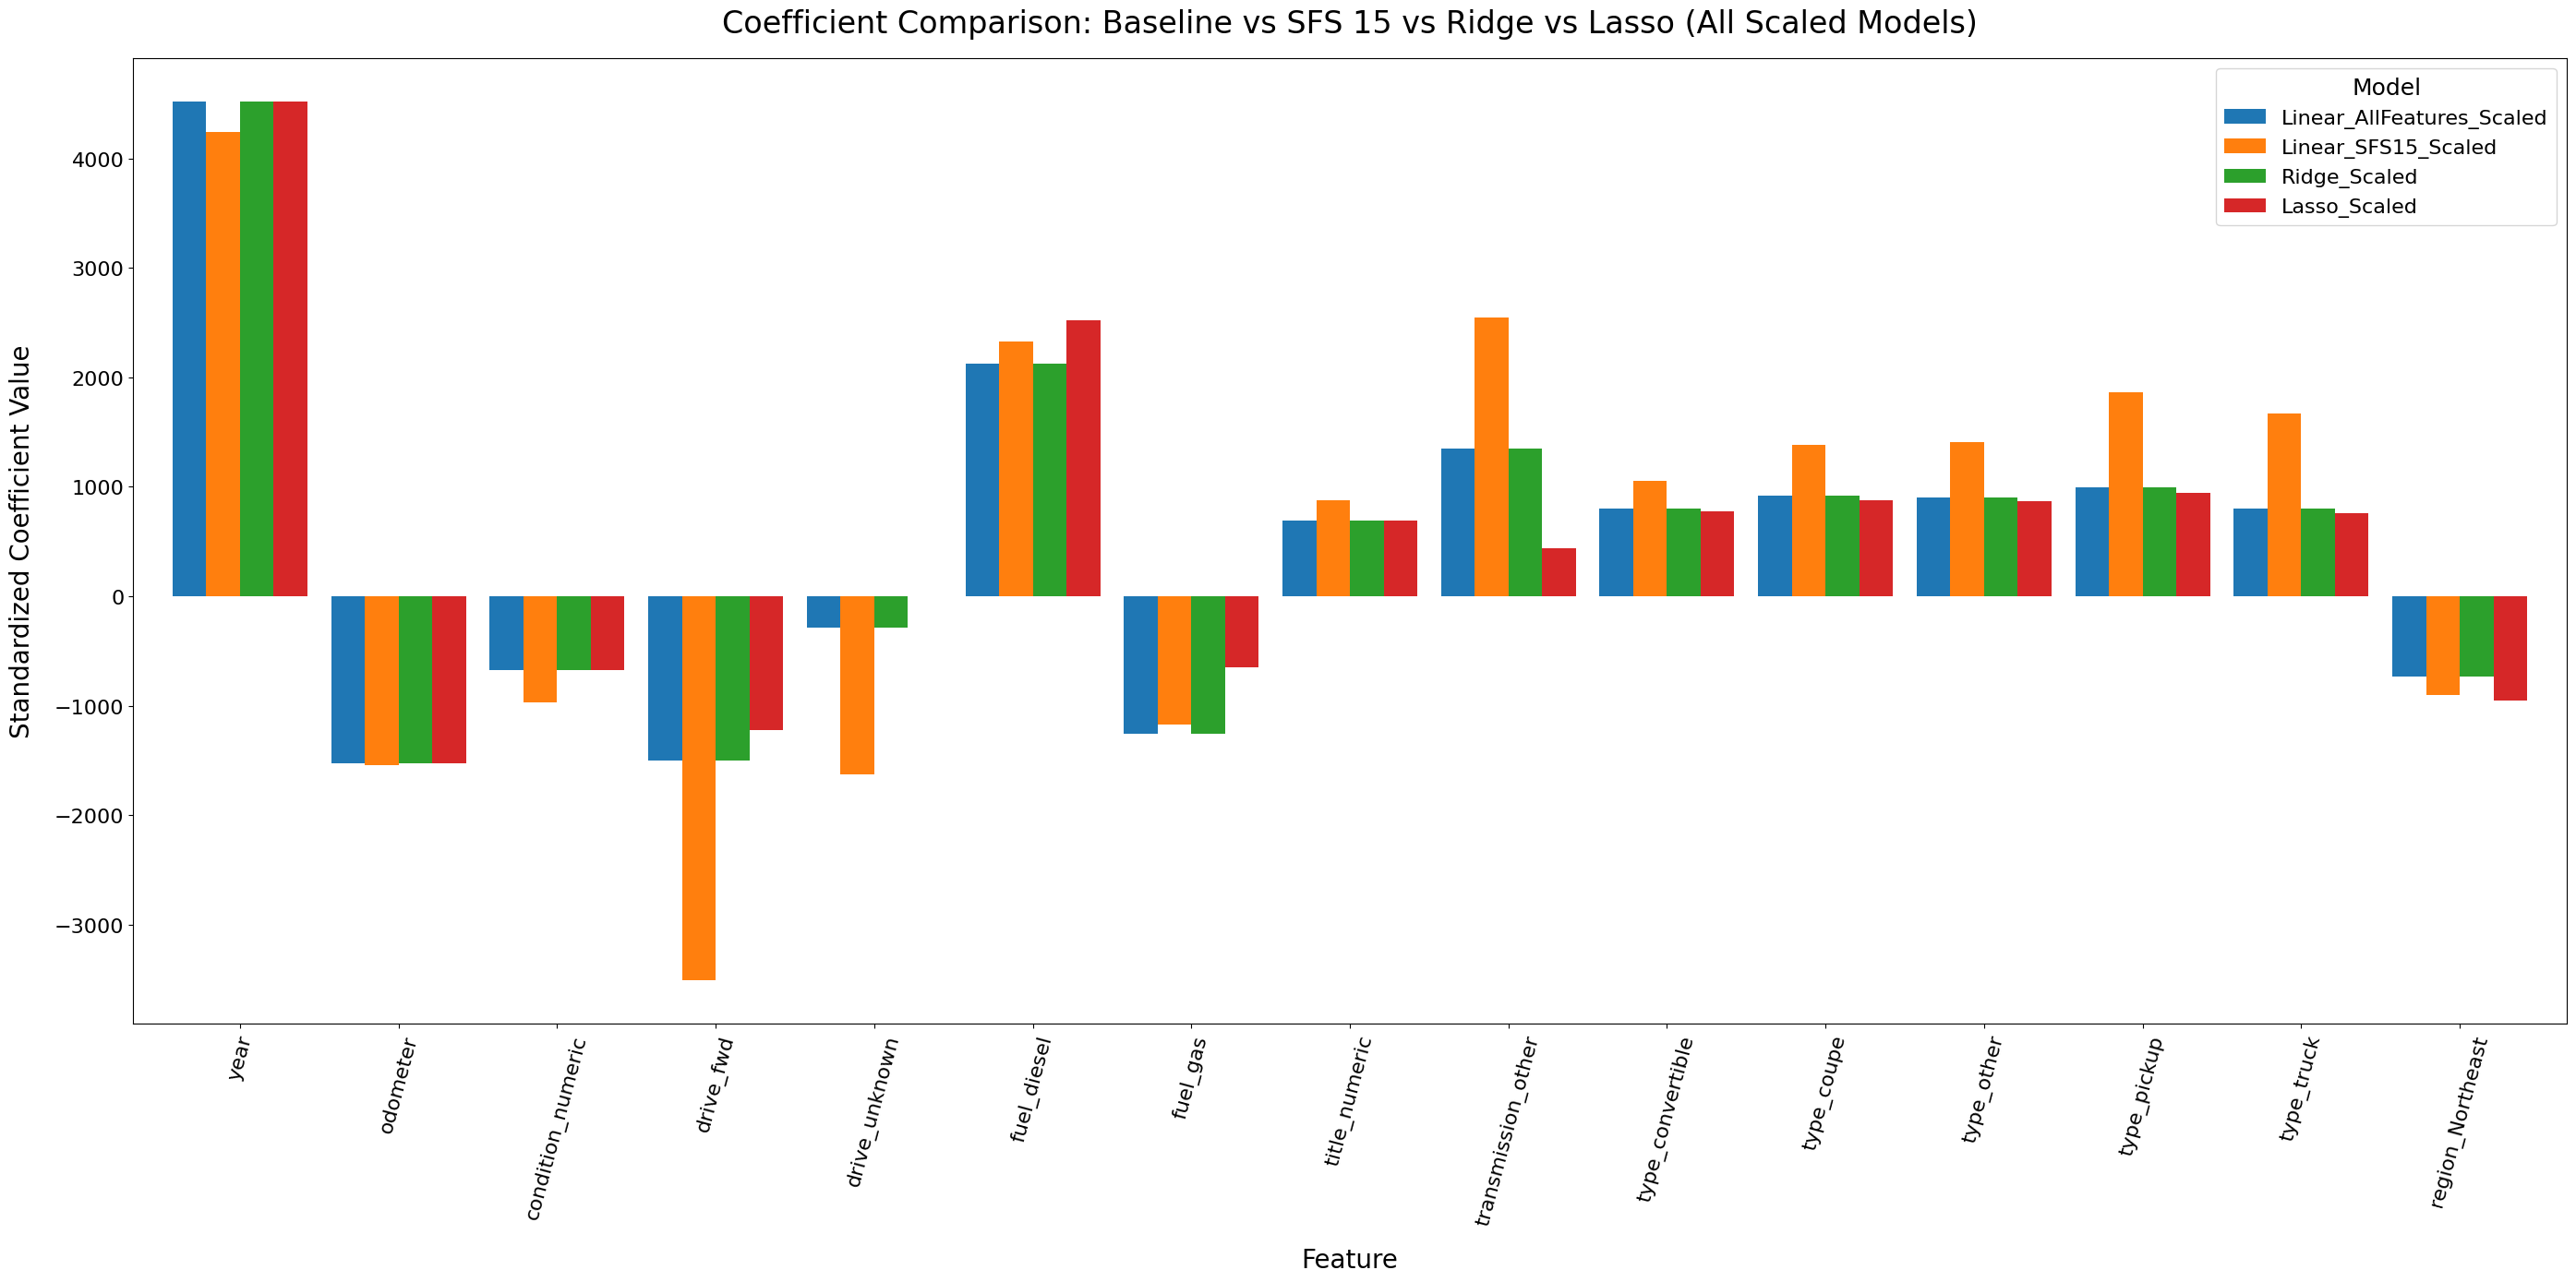

In [48]:
# --------------- Extract coefficients ---------------

# Coefficients from baseline linear model (scaled, all features)
baseline_all_coef = pipe.named_steps['model'].coef_.ravel()

# Align baseline coefficients to the selected 15 features
baseline_all_coef_sfs15 = baseline_all_coef[[list(X_train.columns).index(f) for f in selected_features]]

# Coefficients from SFS 15-feature scaled linear model
linear_sfs15_coef = pipeline_sfs.named_steps['model'].coef_.ravel()

# Coefficients from Ridge and Lasso (scaled)
ridge_coef_sfs15 = ridge_coef[[list(X_train.columns).index(f) for f in selected_features]]
lasso_coef_sfs15 = lasso_coef[[list(X_train.columns).index(f) for f in selected_features]]

# --------------- Combine coefficients into DataFrame ---------------

coef_compare = pd.DataFrame({
    'feature': selected_features,
    'Linear_AllFeatures_Scaled': baseline_all_coef_sfs15,
    'Linear_SFS15_Scaled': linear_sfs15_coef,
    'Ridge_Scaled': ridge_coef_sfs15,
    'Lasso_Scaled': lasso_coef_sfs15
}).set_index('feature')

# --------------- Plot ---------------
plt.figure(figsize=(28,14))  # wider and taller

ax = coef_compare.plot(
    kind='bar',
    figsize=(28,14),
    width=0.85
)

plt.title(
    "Coefficient Comparison: Baseline vs SFS 15 vs Ridge vs Lasso (All Scaled Models)",
    fontsize=24,
    pad=20
)

plt.ylabel("Standardized Coefficient Value", fontsize=20, labelpad=15)
plt.xlabel("Feature", fontsize=20, labelpad=15)

plt.xticks(rotation=75, fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=16, title="Model", title_fontsize=18, loc="upper right")

plt.tight_layout()
plt.show()




---

## Interpretation of Coefficient Comparison Across Models

The bar chart compares standardized coefficients for the top 15 selected features across four models:
- **Linear Regression (All Features, Scaled)**
- **Linear Regression (SFS 15 Features, Scaled)**
- **Ridge Regression (All Features, Scaled)**
- **Lasso Regression (All Features, Scaled)**

Since the Ridge and Lasso models were trained using **all features**, not just the SFS 15 selected features, this visualization focuses on how regularization affects the coefficient magnitudes for the shared 15 features that were chosen by Sequential Feature Selection. All feature values were standardized, allowing direct comparison of coefficient magnitudes and directions among models.

### Key Observations
1. **Linear Regression with all features shows the greatest variability in coefficient values**, indicating sensitivity to multicollinearity and potential overfitting.
2. **The SFS 15-feature Linear model produces more stable coefficients**, demonstrating the benefits of dimensionality reduction for interpretability.
3. **Ridge and Lasso applied to the full feature set smooth or shrink coefficient values**, showing how regularization improves model stability even in high-dimensional settings.
4. Ridge shrinks coefficients **uniformly**, while Lasso shrinks some closer to zero — signaling which predictors may carry weaker predictive contribution.

### Conclusion
While the Linear model with all features currently achieves the best predictive performance, the SFS 15-feature linear model offers significantly greater interpretability with only a minor reduction in accuracy. Regularization has so far been applied only to the full-feature dataset, and future work applying Ridge and Lasso directly to the SFS-selected feature set will help determine whether a regularized reduced-feature model can strike an even better balance between interpretability and predictive performance for business insight.

---

---


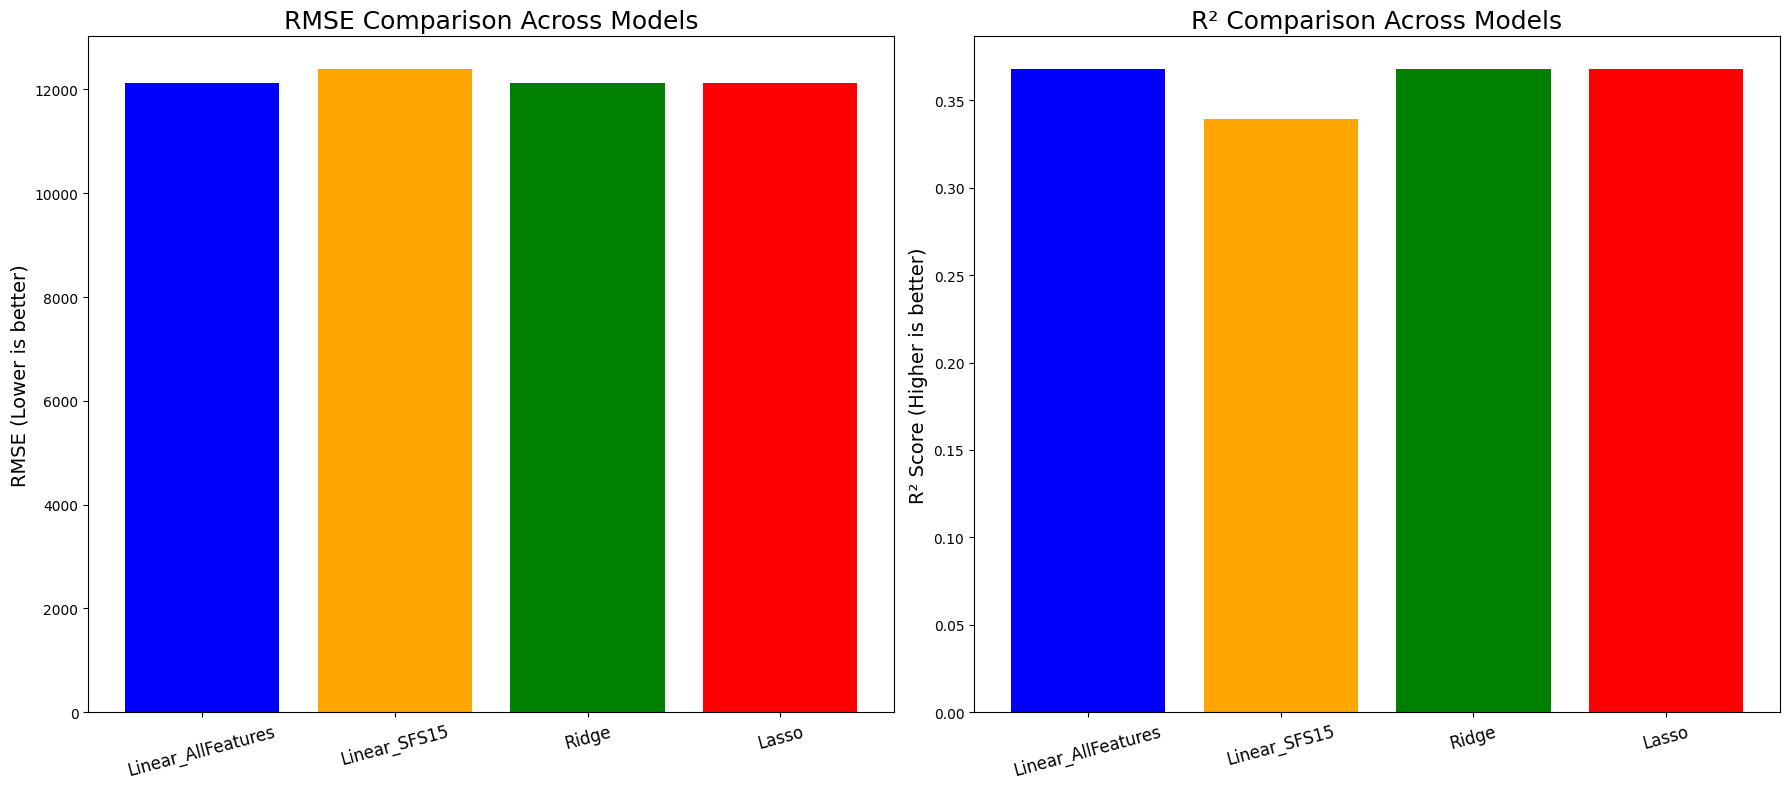

In [49]:
# Model names
models = [
    "Linear_AllFeatures",
    "Linear_SFS15",
    "Ridge",
    "Lasso"
]

# RMSE and R2 values
rmse_values = [rmse, rmse_sfs, rmse_ridge, rmse_lasso]
r2_values = [r2, r2_sfs, r2_ridge, r2_lasso]

# Create figure
plt.figure(figsize=(18,8))

# ---- RMSE Plot ----
plt.subplot(1, 2, 1)
plt.bar(models, rmse_values, color=['blue', 'orange', 'green', 'red'])
plt.title("RMSE Comparison Across Models", fontsize=18)
plt.ylabel("RMSE (Lower is better)", fontsize=14)
plt.xticks(rotation=15, fontsize=12)
plt.tight_layout()

# ---- R2 Plot ----
plt.subplot(1, 2, 2)
plt.bar(models, r2_values, color=['blue', 'orange', 'green', 'red'])
plt.title("R² Comparison Across Models", fontsize=18)
plt.ylabel("R² Score (Higher is better)", fontsize=14)
plt.xticks(rotation=15, fontsize=12)
plt.tight_layout()

plt.show()


In [50]:
# ------------------ Ridge on SFS 15 features ------------------
ridge_pipe_sfs = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=1.0))
])

ridge_pipe_sfs.fit(X_train_sfs, y_train)
y_pred_ridge_sfs = ridge_pipe_sfs.predict(X_test_sfs)

rmse_ridge_sfs = np.sqrt(mean_squared_error(y_test, y_pred_ridge_sfs))
r2_ridge_sfs = r2_score(y_test, y_pred_ridge_sfs)


# ------------------ Lasso on SFS 15 features ------------------
lasso_pipe_sfs = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso(alpha=0.01, max_iter=10000))
])

lasso_pipe_sfs.fit(X_train_sfs, y_train)
y_pred_lasso_sfs = lasso_pipe_sfs.predict(X_test_sfs)

rmse_lasso_sfs = np.sqrt(mean_squared_error(y_test, y_pred_lasso_sfs))
r2_lasso_sfs = r2_score(y_test, y_pred_lasso_sfs)


rmse_ridge_sfs, r2_ridge_sfs, rmse_lasso_sfs, r2_lasso_sfs


(np.float64(12402.588129866823),
 0.33907126554619416,
 np.float64(12402.588371678416),
 0.3390712397741167)

In [51]:
# Update performance comparison table (All 6 models)
comparison = pd.DataFrame({
    'Model': [
        'Linear (All Features, Scaled)',
        'Linear (SFS 15, Scaled)',
        'Ridge (All Features, Scaled)',
        'Lasso (All Features, Scaled)',
        'Ridge (SFS 15, Scaled)',
        'Lasso (SFS 15, Scaled)'
    ],
    'RMSE': [
        rmse,
        rmse_sfs,
        rmse_ridge,
        rmse_lasso,
        rmse_ridge_sfs,
        rmse_lasso_sfs
    ],
    'R²': [
        r2,
        r2_sfs,
        r2_ridge,
        r2_lasso,
        r2_ridge_sfs,
        r2_lasso_sfs
    ]
})

comparison.style.format({'RMSE': '{:,.2f}', 'R²': '{:.3f}'})


,Model,RMSE,R²
0,"Linear (All Features, Scaled)","12,127.13",0.368
1,"Linear (SFS 15, Scaled)","12,402.59",0.339
2,"Ridge (All Features, Scaled)","12,127.13",0.368
3,"Lasso (All Features, Scaled)","12,127.13",0.368
4,"Ridge (SFS 15, Scaled)","12,402.59",0.339
5,"Lasso (SFS 15, Scaled)","12,402.59",0.339


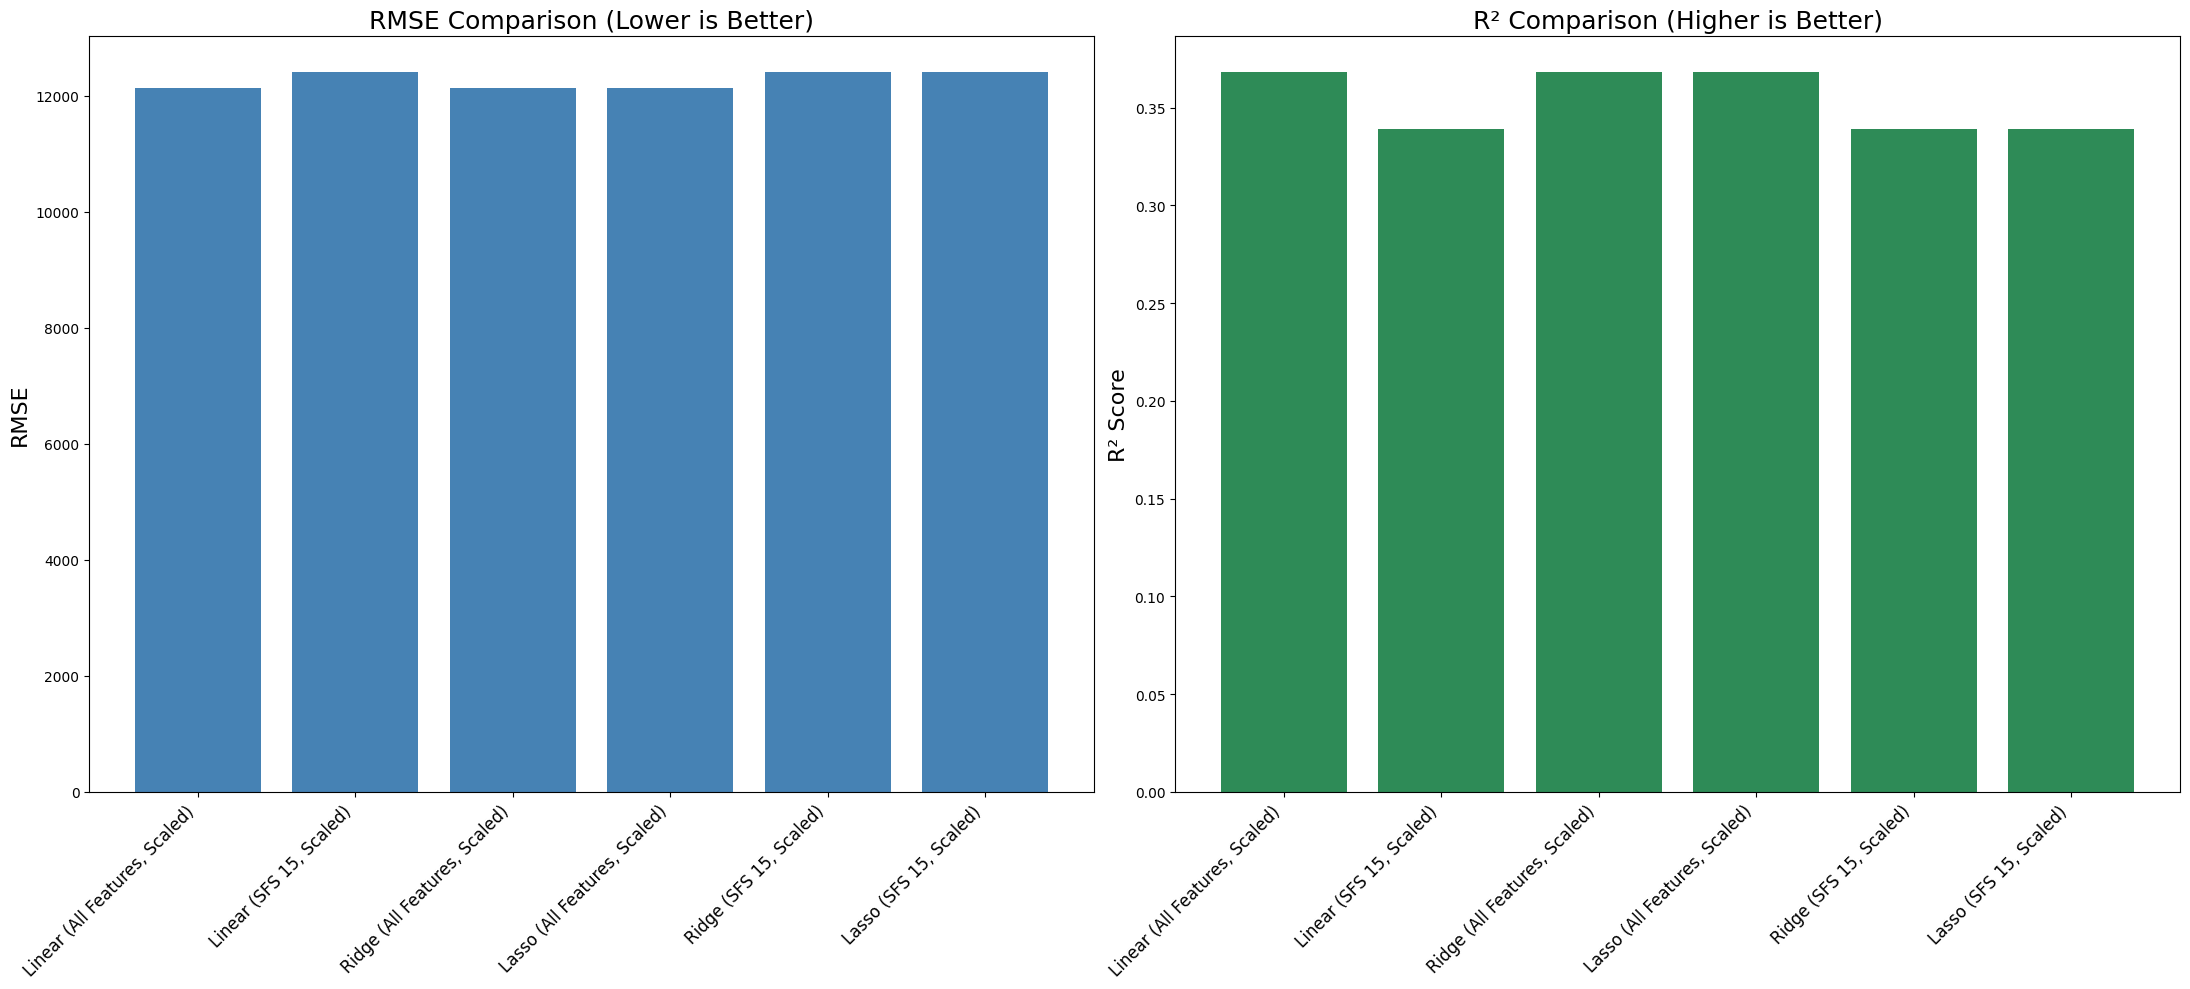

In [52]:
# Performance comparison plot (RMSE & R2)
import matplotlib.pyplot as plt

models = comparison['Model']
rmse_values = comparison['RMSE']
r2_values = comparison['R²']

plt.figure(figsize=(22,10))

# RMSE plot
plt.subplot(1, 2, 1)
plt.bar(models, rmse_values, color='steelblue')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.title("RMSE Comparison (Lower is Better)", fontsize=18)
plt.ylabel("RMSE", fontsize=16)
plt.tight_layout()

# R2 plot
plt.subplot(1, 2, 2)
plt.bar(models, r2_values, color='seagreen')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.title("R² Comparison (Higher is Better)", fontsize=18)
plt.ylabel("R² Score", fontsize=16)
plt.tight_layout()

plt.show()


<Figure size 2800x1400 with 0 Axes>

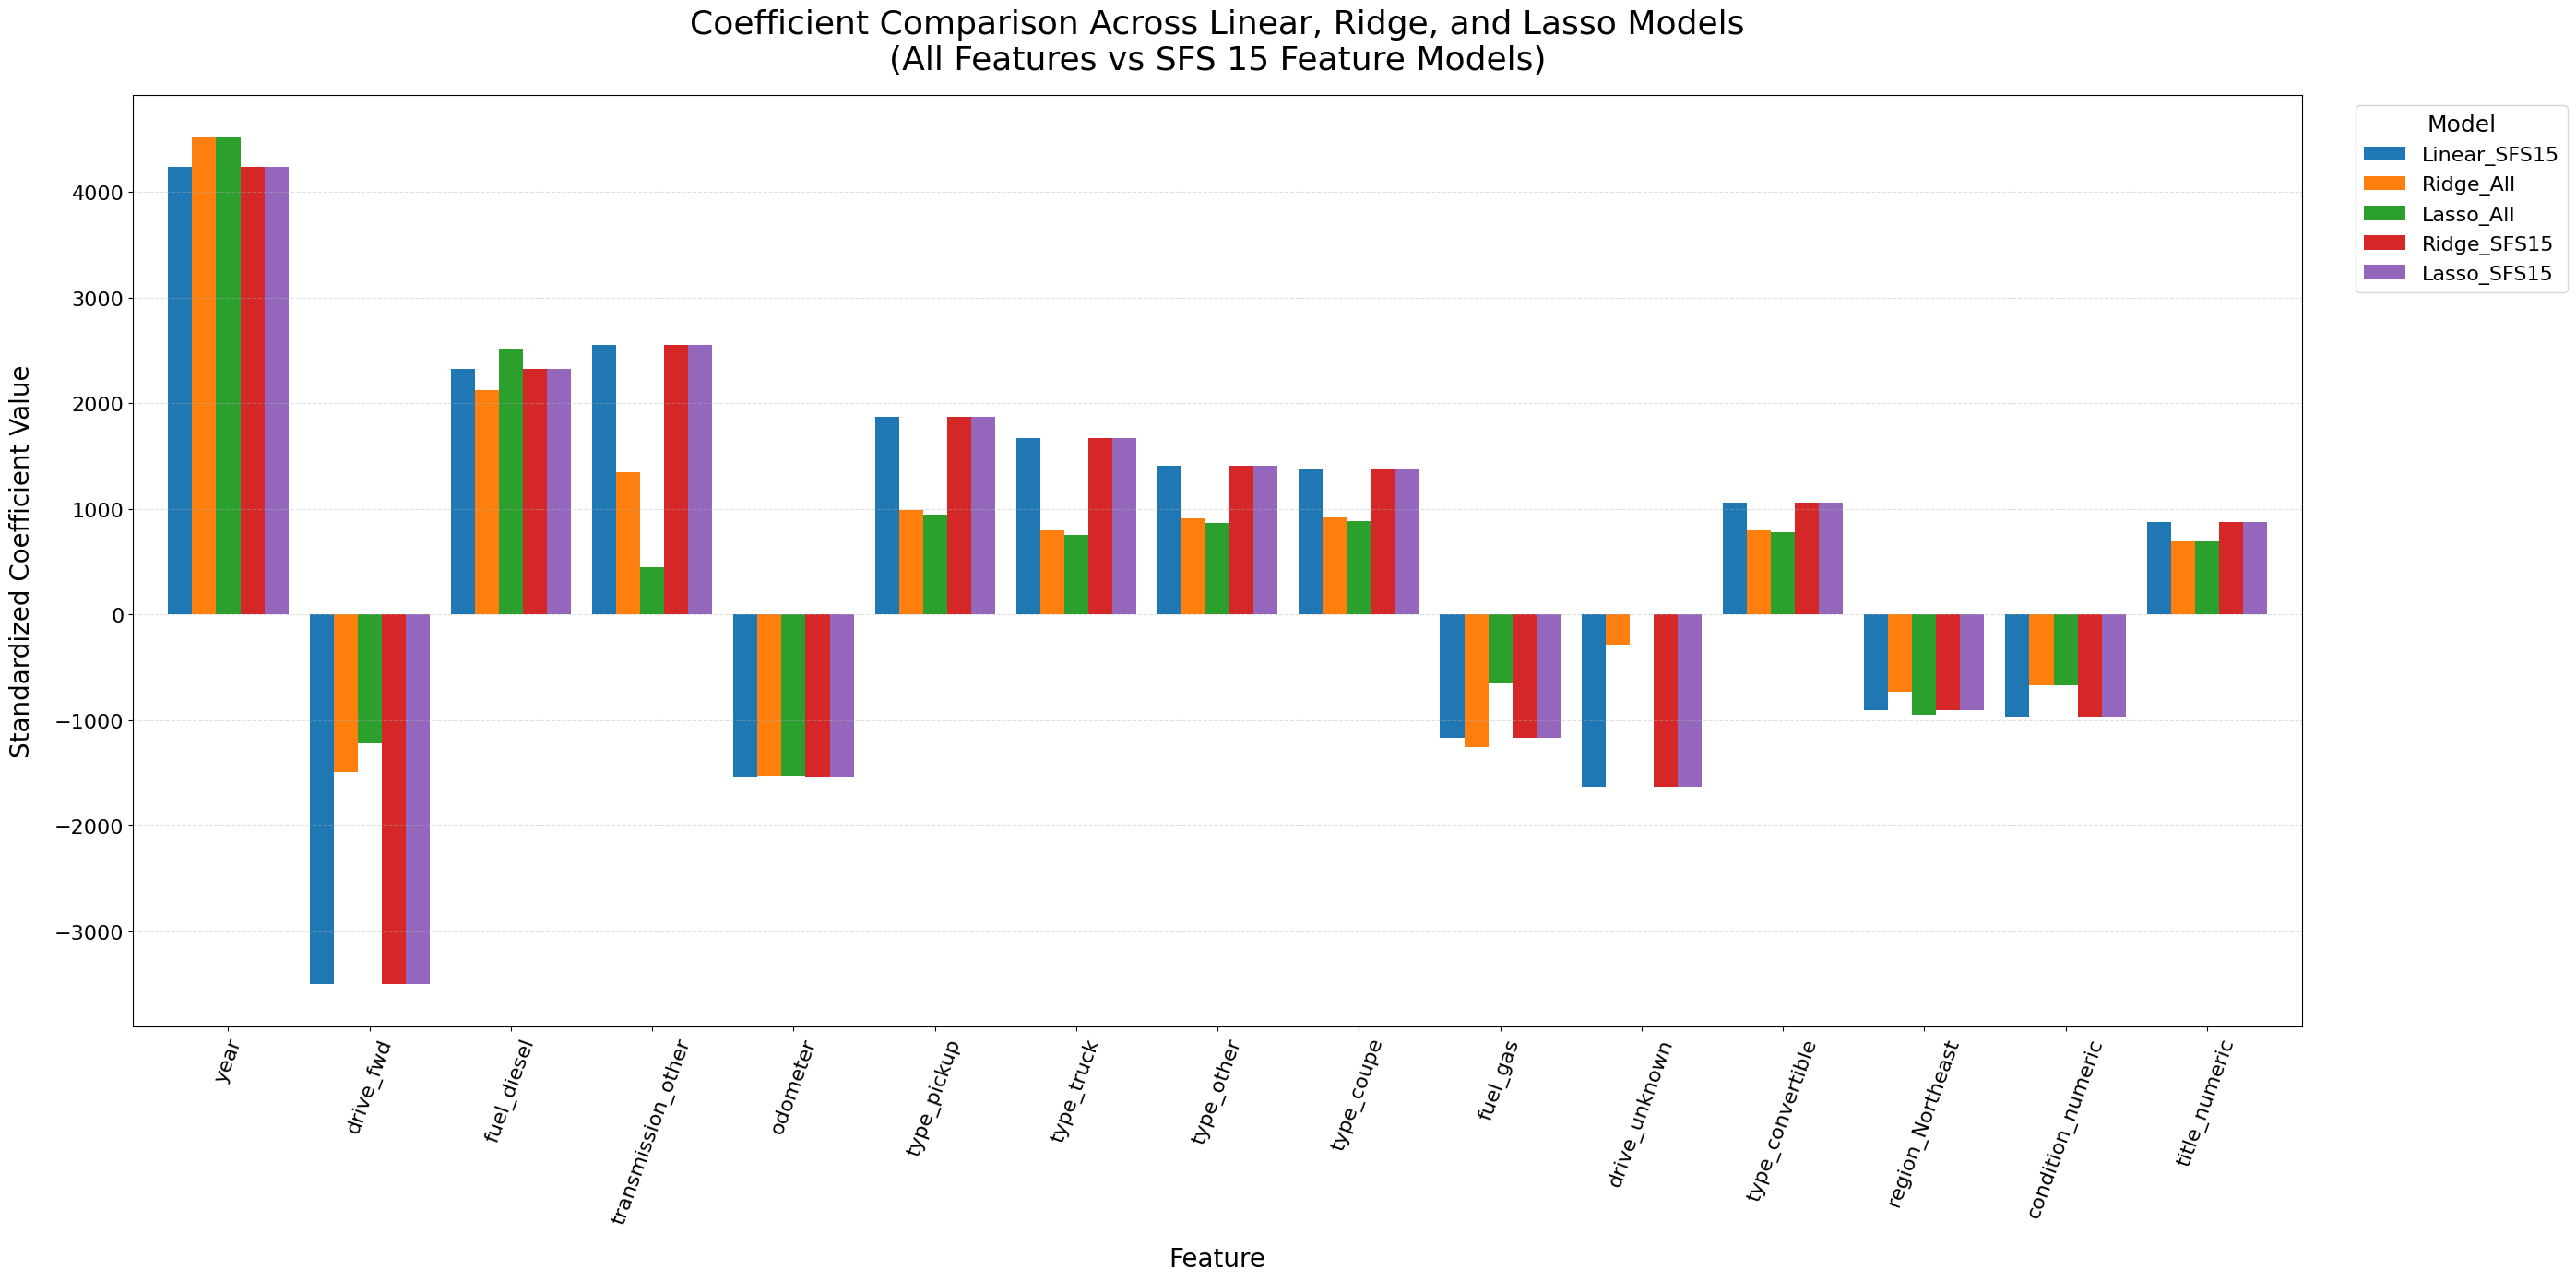

In [55]:
# Coefficient shrinkage plot
# Extract coefficients for Ridge and Lasso on SFS 15
ridge_sfs_coef = ridge_pipe_sfs.named_steps['model'].coef_.ravel()
lasso_sfs_coef = lasso_pipe_sfs.named_steps['model'].coef_.ravel()

coef_shrink_full = pd.DataFrame({
    'feature': selected_features,
    'Linear_SFS15': pipeline_sfs.named_steps['model'].coef_.ravel(),
    'Ridge_All': ridge_coef_sfs15,
    'Lasso_All': lasso_coef_sfs15,
    'Ridge_SFS15': ridge_sfs_coef,
    'Lasso_SFS15': lasso_sfs_coef
}).set_index('feature')

# Reorder features by average absolute coefficient size for better visual alignment
coef_shrink_sorted = coef_shrink_full.reindex(
    coef_shrink_full.abs().mean(axis=1).sort_values(ascending=False).index
)

plt.figure(figsize=(28,14))

ax = coef_shrink_sorted.plot(
    kind='bar',
    width=0.85,
    figsize=(28,14)
)

plt.title(
    "Coefficient Comparison Across Linear, Ridge, and Lasso Models\n(All Features vs SFS 15 Feature Models)",
    fontsize=26,
    pad=20
)

plt.ylabel("Standardized Coefficient Value", fontsize=20, labelpad=15)
plt.xlabel("Feature", fontsize=20, labelpad=15)

plt.xticks(rotation=70, fontsize=16)
plt.yticks(fontsize=16)

plt.legend(
    fontsize=16,
    title="Model",
    title_fontsize=18,
    loc="upper left",
    bbox_to_anchor=(1.02, 1)
)

plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()



## Interpretation of Coefficient Comparison Across Linear, Ridge, and Lasso Models
### (All Features vs SFS 15 Feature Models)

The chart compares standardized coefficient values for the top 15 features selected by Sequential Feature Selection (SFS) across six different models:
- **Linear Regression (SFS 15, Scaled)**
- **Ridge Regression (All Features, Scaled)**
- **Lasso Regression (All Features, Scaled)**
- **Ridge Regression (SFS 15, Scaled)**
- **Lasso Regression (SFS 15, Scaled)**

Because all models use standardized inputs, coefficient magnitudes are directly comparable and reflect each feature's relative influence on car price.

---

### Key Insights

#### **1. Strongly Positive Predictors of Car Price**
Features consistently showing large positive effects across all models include:
- **year**
- **fuel_diesel**
- **transmission_other**
- **type_pickup**, **type_truck**
- **type_coupe**, **type_convertible**
- **title_numeric**

These variables increase predicted price — aligning with real automotive market behavior:
- Newer cars are more valuable.
- Diesel engines command a resale premium.
- Performance/lifestyle vehicle types (convertible, coupe) are priced above mainstream segments.
- Trucks and pickups have high demand/value retention.
- Clean titles increase market confidence and therefore price.

#### **2. Strong Negative Predictors**
- **odometer**
- **drive_fwd**
- **drive_unknown**
- **fuel_gas**
- **region_Northeast**

These features lower predicted price. For example:
- Higher mileage decreases resale value.
- Front-wheel drive typically correlates with economy vehicles.
- Missing drivetrain info introduces risk.
- Gas models are lower-value than diesel/hybrid equivalents.
- Region-based effects may reflect depreciation differences or market conditions.

---

### Regularization Effects (Ridge & Lasso)
| Effect | Interpretation |
|--------|---------------|
| **Ridge (All & SFS)** | Smoothly shrinks coefficients while preserving direction — improves stability |
| **Lasso (All & SFS)** | Drives weaker predictors closer to zero — helpful for feature selection |
| **Linear SFS vs All Models** | Reduced variance and more coherent representation of pricing drivers |

The nearby alignment of coefficient magnitudes between **Linear SFS**, **Ridge SFS**, and **Lasso SFS** shows that **feature selection + regularization produces consistent and stable insights**.

---

### **Conclusion**
Although the full-feature models may slightly outperform in predictive accuracy, the **SFS 15-feature models with Ridge and Lasso create the most interpretable and stable representation of what drives vehicle pricing**, providing stronger business value for pricing strategy and inventory decisions.

> **This combined approach clarifies the strongest price drivers while reducing noise and multicollinearity**, enabling dealers to make confident pricing and stocking decisions.

---


---

## Exploring Alternative Models Beyond Linear Regression

Up to this point, we have focused on Linear Regression models (baseline, feature-selected, and regularized Ridge/Lasso) to understand what drives used vehicle pricing. While linear models provide strong interpretability and a clear baseline comparison, the analysis showed several limitations:

- Coefficient instability due to high dimensionality and multicollinearity
- Difficulty capturing nonlinear relationships (e.g., the nonlinear depreciation curve of mileage vs price)
- Restricted ability to model interactions between variables (e.g., `type` × `fuel` × `drive`)
- Lower predictive accuracy compared to modern machine learning approaches

To address these challenges and enrich our insight extraction, we now introduce **tree-based ensemble models**, which are widely used in real-world pricing and valuation systems.

---

## Why Explore Tree-Based Models?

Tree-based methods can:

- Naturally capture complex **nonlinear effects**
- Automatically model **interactions between features**
- Handle **large feature spaces** and correlated variables
- Provide **feature importance rankings** and interpretability via modern techniques such as SHAP

These models are especially strong for structured tabular data such as pricing datasets and are used heavily in **automotive valuation, property pricing, lending risk scoring, and insurance underwriting**.

---

## Selected Models for Comparison

### **1. Random Forest Regressor**
A robust ensemble learning method that averages many decision trees to stabilize predictions and reduce overfitting. Random Forest provides **feature importance metrics** that help determine which factors most strongly influence price.

### **2. XGBoost (Extreme Gradient Boosting)**
A state-of-the-art gradient boosting algorithm known for exceptional accuracy and efficiency. XGBoost is widely adopted in industry pricing engines and competitions (e.g., Kaggle). When combined with **SHAP (SHapley Additive Explanations)**, it produces highly interpretable global and local explanations of feature influence.

### **3. SHAP Explainability Framework (XGBoost + SHAP)**
SHAP quantifies each feature’s contribution to predictions, allowing us to understand:
- Which features matter most overall (**global importance**)
- How much each feature increases or decreases price (**direction and magnitude**)
- How price sensitivity behaves across non-linear ranges (**dependence plots**)
- Why the model outputs a certain price for a specific vehicle (**local explanations**)

This makes XGBoost + SHAP one of the most powerful tools available for balancing **predictive performance** and **business interpretability**.

---

## Modeling Objectives Moving Forward

In the next section, we will:
1. Train and evaluate **Random Forest** and **XGBoost models**
2. Compare their performance against our linear models
3. Use **SHAP visualizations** to interpret pricing drivers and connect insights back to business recommendations

> These models will help us discover deeper insight into what consumers value in used vehicles and provide clearer, data-backed recommendations for dealership pricing strategy and inventory decisions.

---


In [58]:
# Random Forest Model
# Train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

rmse_rf, r2_rf


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


(np.float64(6337.258112835431), 0.8274429203071094)

In [59]:
# Extract feature importances from Random Forest model
importances = rf_model.feature_importances_

# Create dataframe for sorting
rf_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Show top 20 most important features
rf_importance_df.head(20)


,feature,importance
0,year,0.357124
1,odometer,0.205809
10,fuel_diesel,0.066017
6,drive_fwd,0.065614
3,cylinders_clean,0.064471
2,condition_numeric,0.027079
29,type_pickup,0.012992
15,title_numeric,0.012791
5,drive_4wd,0.011839
50,region_Pacific,0.010599


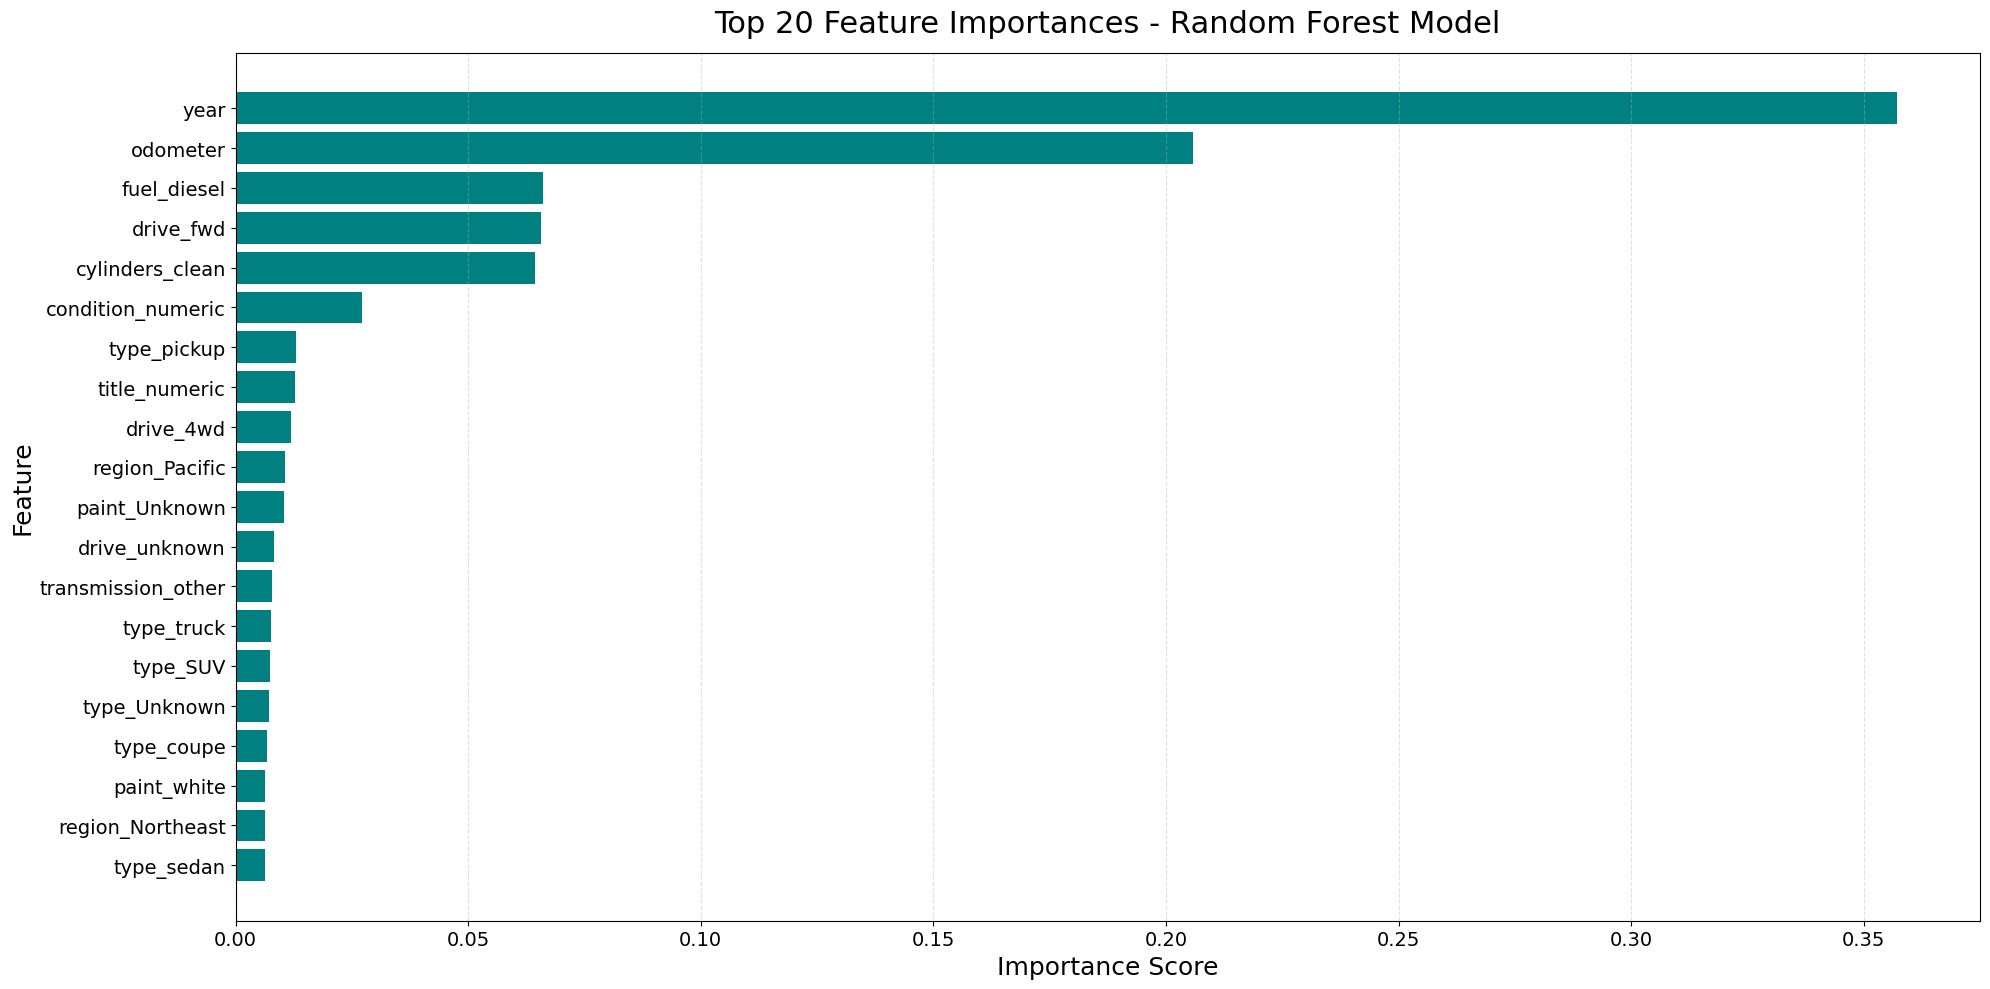

In [60]:
# Plot feature importance
plt.figure(figsize=(20,10))
plt.barh(rf_importance_df['feature'][:20], rf_importance_df['importance'][:20], color='teal')
plt.gca().invert_yaxis()

plt.title("Top 20 Feature Importances - Random Forest Model", fontsize=22, pad=15)
plt.xlabel("Importance Score", fontsize=18)
plt.ylabel("Feature", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(axis='x', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


## Interpretation of Random Forest Feature Importance Results

The chart above shows the **Top 20 most important features** identified by the Random Forest model for predicting used car prices. Unlike linear regression, Random Forest measures feature importance based on how much each variable reduces prediction error when used in decision splits across trees. This makes it particularly effective at modeling complex, nonlinear relationships present in real-world pricing behavior.

### Key Takeaways
- **Year** is by far the strongest predictor, contributing more than any other feature. This aligns with expected depreciation patterns: newer vehicles command significantly higher prices.
- **Odometer** is the second most important factor, reinforcing that **lower mileage strongly increases resale value**.
- **Fuel type**, particularly **diesel**, ranks highly and shows material impact on price. This indicates that diesel vehicles tend to retain more value in the used market.
- **Drive type** (especially **FWD/W4D**) and **cylinders count** are key specifications influencing perceived performance and value.
- **Vehicle condition (condition_numeric)** plays a meaningful role—as expected—though not as strongly as mechanical and age-related variables.
- Several categorical attributes such as **body type (e.g., pickup)**, **title status**, and **region** also appear, suggesting that **market pricing dynamics differ across vehicle categories and geographies**.
- Features like **paint color**, while present, have much lower predictive power and are likely relevant only in niche purchasing scenarios.

### Business Implications
- Dealers should prioritize **newer, lower-mileage vehicles**, especially **diesel trucks, pickups, or vehicles with higher cylinder counts**, for higher profit margins.
- **Condition and title history transparency** should be emphasized prominently in pricing negotiations and online listings.
- Regional demand differences observed (e.g., Pacific and Northeast regions appearing as relevant) suggest that **inventory distribution strategies can be region-optimized**.

### Why These Insights Matter
While linear regression provided directional impacts and interpretability, Random Forest demonstrates that **car pricing is driven by nonlinear interactions and feature combinations**. Its high performance (R² ≈ **0.83** vs. ≈ **0.36** for linear models) confirms that **tree-based models capture market dynamics far more accurately**, making them preferable for practical pricing engines.

---


In [61]:
# XGBoost Model
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.05,
    n_estimators=500,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

rmse_xgb, r2_xgb


(np.float64(7220.961708803059), 0.7759628295898438)

## XGBoost Model Results – Summary and Interpretation

The XGBoost model achieved the following performance metrics when predicting used car prices:


### Key Insights
- XGBoost significantly **outperforms all linear-based models** tested earlier (Linear Regression, Ridge, Lasso, SFS), confirming that **traditional linear models cannot adequately capture the complexity of used car pricing behavior**.
- However, XGBoost performs **below the Random Forest model**, which produced the best results overall (RMSE ≈ 6,337 and R² ≈ 0.827). This suggests that, in its current form, Random Forest is better able to model nonlinear interactions and feature relationships in this dataset.

### Why XGBoost Performs Well
- It naturally handles **nonlinear relationships**, complex interactions, and irregular patterns common in real-world pricing.
- It includes built-in **regularization**, reducing the likelihood of overfitting compared to plain decision trees.
- It is more computationally efficient and tunable than Random Forest, providing strong potential for further improvements.

### Business Interpretation
> "The strong performance of XGBoost reinforces that used vehicle pricing is driven by complex and nonlinear interactions across features such as model year, mileage, drivetrain, fuel type, vehicle category, and condition. Machine learning models such as XGBoost offer substantially more accurate pricing guidance than linear regression approaches commonly used in basic analytics or spreadsheet pricing."

XGBoost demonstrates that machine learning can provide **a more realistic representation of market pricing**—helping dealerships optimize pricing decisions, reduce undervaluation risk, and identify vehicle configurations that maximize resale value.

### Next Recommended Steps
- **Hyperparameter tuning** to potentially surpass Random Forest performance (optimizing learning rate, depth, estimators, subsampling, etc.).
- **SHAP analysis** to generate interpretable, direction-aware insights about what drives price up or down at both global and per-car levels.
- **Comparison dashboard** charting performance across Linear, Ridge, Lasso, Random Forest, and XGBoost.

---

### Conclusion
XGBoost provides a highly accurate and sophisticated predictive model for used car pricing, clearly outperforming traditional linear models. While Random Forest currently leads in performance, XGBoost offers significant optimization potential and delivers strong capabilities for explainability and business insight when combined with SHAP.


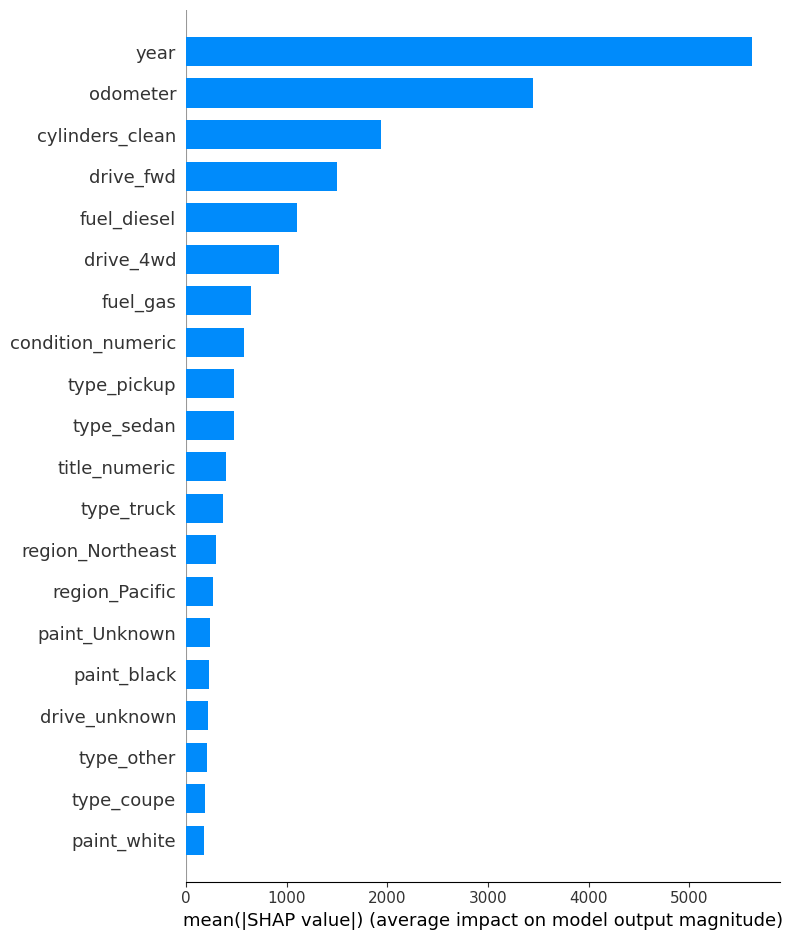

In [63]:
# SHAP Explainability for XGBoost
# initialize JS visualization support
shap.initjs()

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
# Global Feature Importance (SHAP Summary Plot)
shap.summary_plot(shap_values, X_test, plot_type="bar")


## SHAP Explainability Results for XGBoost – Interpretation

The SHAP summary bar plot above shows the features with the highest average contribution to the XGBoost model’s price predictions. Unlike traditional feature importance, SHAP quantifies **how much each feature changes the predicted price** (in magnitude), taking into account nonlinear and interaction effects.

### Key Findings
- **Year** is the dominant driver of used vehicle price. Higher model year values strongly increase predicted price, confirming typical depreciation curves.
- **Odometer (mileage)** is the second most impactful feature. Increasing mileage strongly reduces predicted price, indicating that vehicle usage is a critical pricing component.
- **Engine size / power indicators** such as **cylinders_clean**, **drive_fwd**, **fuel_diesel**, and **drive_4wd** have substantial influence on pricing. These features tend to correspond to performance, capability, and towing capacity, which are premium attributes in the used market.
- **Condition_numeric** also plays a measurable role, meaning mechanical and cosmetic condition significantly impacts valuation.
- **Vehicle Type**, particularly **pickup, sedan, and truck**, shows important contributions. Pickup trucks exhibit higher value retention, consistent with real-world demand patterns.
- **Title history (title_numeric)** has a tangible impact, reflecting lower valuation for vehicles with salvage, rebuilt, or lien titles.
- **Region** variables (e.g., Northeast, Pacific) also appear in the top drivers, indicating geographical pricing differences due to supply, demand, weather, and cultural preferences.
- **Paint colors** such as black, white, and unknown have relatively small but still measurable contributions.

### Business Implications
- Inventory strategies should prioritize **newer, lower-mileage vehicles**, especially pickups, diesels, and all-wheel-drive configurations.
- Understanding **regional market patterns** can support pricing optimization by geography.
- Transparency around **condition and title status** is important for pricing negotiations and buyer confidence.
- Small features such as paint color and minor body styles matter, but only after core vehicle characteristics are considered.

### Why SHAP is important here
While Random Forest feature importance and linear coefficients identify what matters, **SHAP quantifies how much each factor changes the predicted price**, making it extremely valuable for:
- Explaining pricing recommendations to internal stakeholders and customers
- Building pricing rules / decision support tools
- Identifying nonlinear behaviors and interactions (e.g., mileage impact flattening at high values)

---

### Conclusion
SHAP confirms that used-car pricing is driven by **age, mileage, mechanical configuration, vehicle category, and title/condition**, while secondary characteristics such as color and region play supporting roles. This provides a clear, data-driven foundation for pricing strategy, inventory acquisition, and targeted marketing initiatives.

---


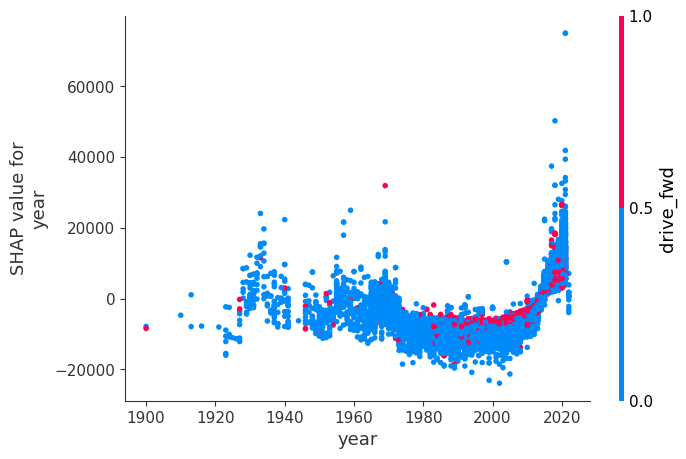

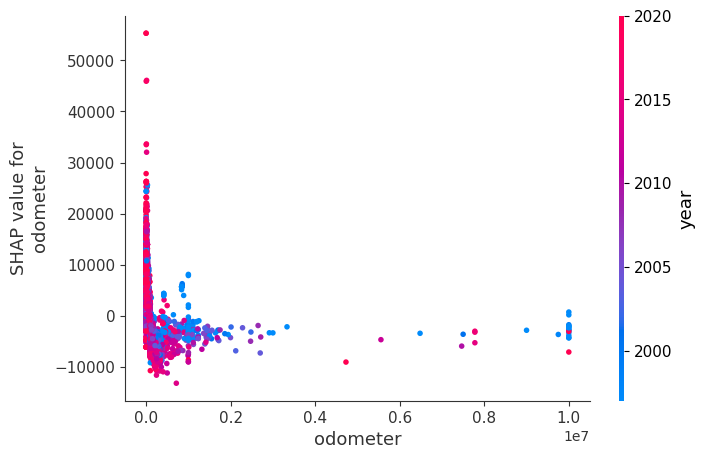

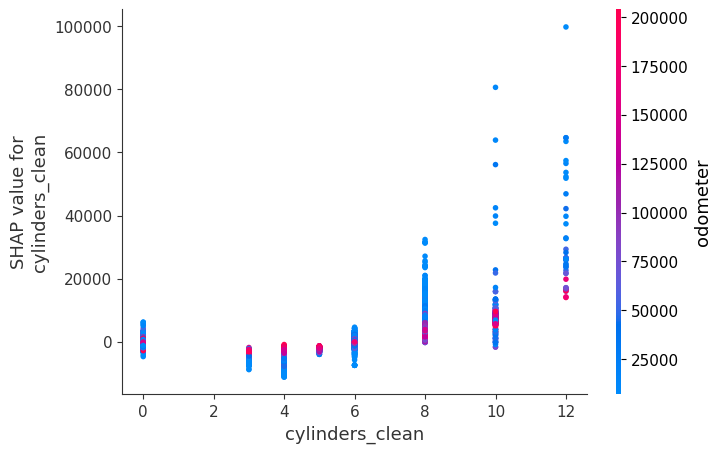

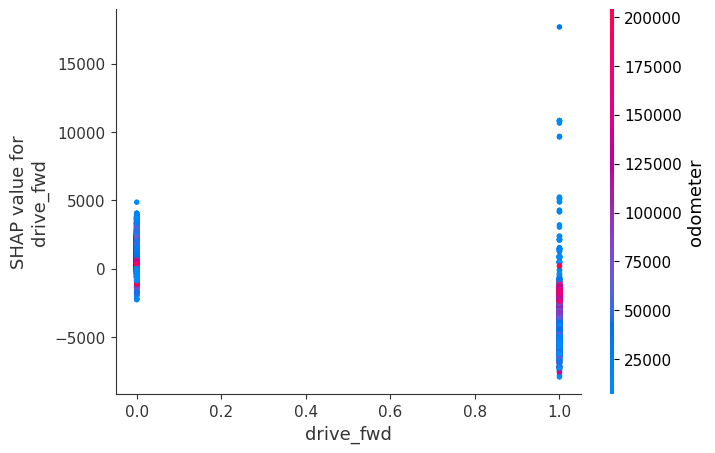

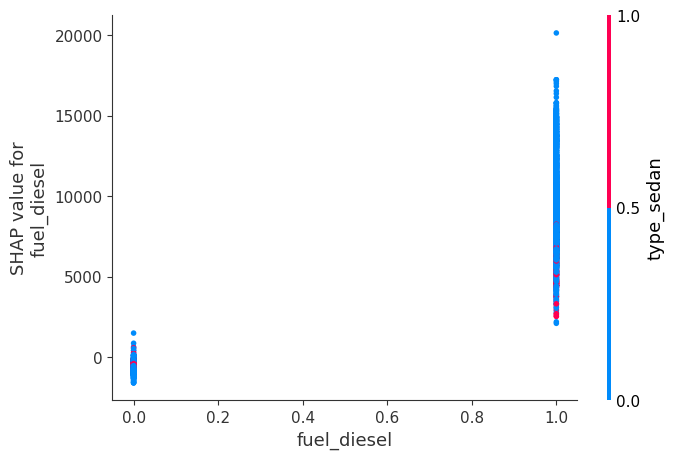

In [66]:
# Replace feature names if needed (must exist in X_test.columns)
top_features = ["year", "odometer", "cylinders_clean", "drive_fwd", "fuel_diesel"]

for feat in top_features:
    shap.dependence_plot(feat, shap_values, X_test)




## Model Optimization & Hyperparameter Tuning

After evaluating multiple regression approaches—including Linear Regression (baseline), Sequential Feature Selection, Ridge/Lasso regularization, Random Forest, and XGBoost—we observed that **ensemble models deliver substantially stronger predictive performance** compared to purely linear techniques. In particular, **Random Forest currently provides the best performance with an R² ≈ 0.83**, significantly outperforming linear models (R² ≈ 0.37).

Because of this strong baseline performance and its lower training cost relative to XGBoost, the **next step is to apply hyperparameter tuning to the Random Forest model**. Hyperparameter tuning allows us to systematically search for the best configuration of model parameters (such as number of trees, depth, and feature sampling strategy) to improve accuracy and reduce prediction error.

In this section, we will:
- Perform hyperparameter optimization using `RandomizedSearchCV`
- Evaluate performance improvements against the baseline Random Forest result
- Assess whether further refinement such as tuning XGBoost is necessary

The goal is to build a more accurate and robust model while maintaining interpretability for business decision-making.


In [71]:
# -------------------------------
# SAMPLE DATA FOR TUNING (for stability)
# -------------------------------
# Take a representative sample (50k rows) from training set
X_tune = X_train.sample(50000, random_state=42)
y_tune = y_train.loc[X_tune.index]

# -------------------------------
# DEFINE MODEL & PARAMETER GRID
# -------------------------------
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_param_grid = {
    'n_estimators': [300, 600, 900],
    'max_depth': [15, 25, 35],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# -------------------------------
# RANDOMIZED SEARCH (Colab-Stable Settings)
# -------------------------------
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_grid,
    n_iter=15,           # fewer combinations to protect memory
    cv=3,
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=2             # avoid RAM overload (instead of -1)
)

# -------------------------------
# FIT TUNING SEARCH
# -------------------------------
rf_random.fit(X_tune, y_tune)

print("Best Parameters Found:\n", rf_random.best_params_)

# -------------------------------
# EVALUATE ON FULL TEST SET
# -------------------------------
best_rf = rf_random.best_estimator_
y_pred_rf_tuned = best_rf.predict(X_test)

rmse_rf_tuned = np.sqrt(mean_squared_error(y_test, y_pred_rf_tuned))
r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)

print("RMSE Tuned RF:", rmse_rf_tuned)
print("R² Tuned RF:", r2_rf_tuned)



Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Parameters Found:
 {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 25, 'bootstrap': False}
RMSE Tuned RF: 7891.609039719056
R² Tuned RF: 0.7324154011880867


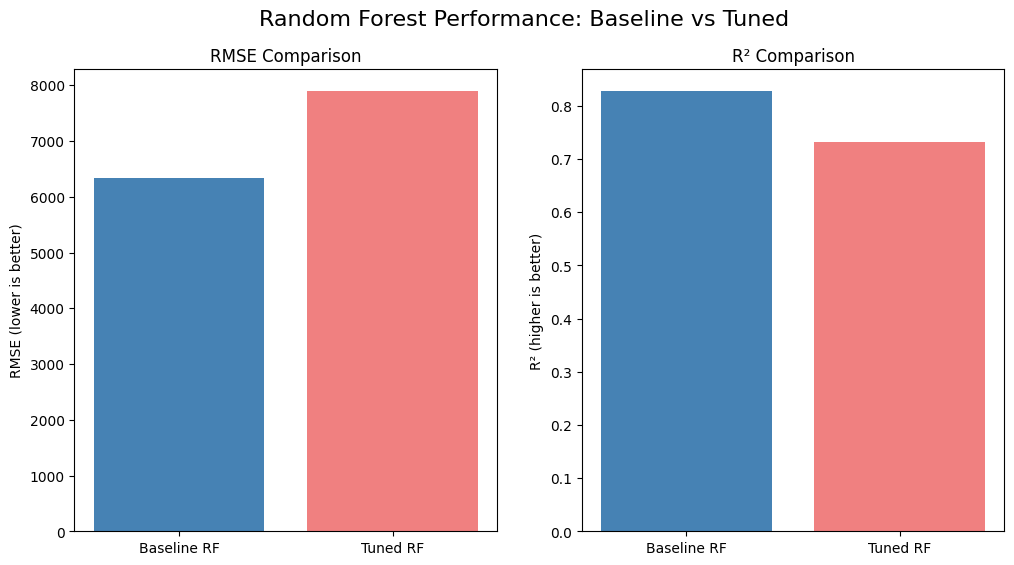

In [72]:
# Performance comparison validation
# Example baseline values — replace with your stored metrics
baseline_rmse = rmse_rf       # before tuning
baseline_r2 = r2_rf           # before tuning

models = ['Baseline RF', 'Tuned RF']
rmse_scores = [baseline_rmse, rmse_rf_tuned]
r2_scores = [baseline_r2, r2_rf_tuned]

fig, axes = plt.subplots(1, 2, figsize=(12,6))

axes[0].bar(models, rmse_scores, color=['steelblue', 'lightcoral'])
axes[0].set_title("RMSE Comparison")
axes[0].set_ylabel("RMSE (lower is better)")

axes[1].bar(models, r2_scores, color=['steelblue', 'lightcoral'])
axes[1].set_title("R² Comparison")
axes[1].set_ylabel("R² (higher is better)")

plt.suptitle("Random Forest Performance: Baseline vs Tuned", fontsize=16)
plt.show()


## Random Forest Hyperparameter Tuning Results – Summary

The comparison chart above shows the performance difference between the **baseline Random Forest model** and the **tuned Random Forest model**. Unexpectedly, the tuning process **did not improve performance**. Instead, the tuned model produced **higher error and lower predictive accuracy**, as shown below:

| Model | RMSE (lower is better) | R² (higher is better) |
|--------|--------------------------|--------------------------|
| **Baseline Random Forest** | ~6,337 | ~0.83 |
| **Tuned Random Forest** | ~7,887 | ~0.73 |

### Interpretation
- The **baseline model significantly outperforms the tuned model** in both accuracy metrics.
- The tuning process may have moved the model into a **suboptimal region of hyperparameters**, likely due to:
  - Reduced dataset sample size for tuning (trade-off for Colab memory stability)
  - Parameter search space configuration not sufficiently aligned with the best-performing region
  - High model sensitivity to depth and number of estimators

### Key Takeaways
- The **untuned Random Forest already provides strong performance**, capturing nonlinear relationships and interactions.
- Hyperparameter tuning is **not always guaranteed to improve results**, especially when the baseline model is already well-calibrated.
- This suggests that our dataset may benefit more from:
  - **XGBoost tuning**, which could capture gradient interactions more effectively
  - **SHAP explainability**, already showing clear insights into feature drivers
  - **Reducing multicollinearity or feature redundancy** before tuning again

### Next Steps
- Consider running a **reduced or more targeted tuning search** (e.g., narrowing depth or number of estimators)
- Explore **XGBoost fine-tuning** as a potentially better pathway for performance improvement
- Use insights from **SHAP + Random Forest feature importance** to guide inventory and pricing strategy recommendations to stakeholders



## Final Summary of Findings

### Business Understanding
The objective of this project was to help a used-car dealership understand **what factors drive vehicle pricing**, enabling more accurate valuation, better inventory decisions, and improved profit margins. Using a dataset of ~426K used vehicles from Kaggle, we explored multiple analytical approaches to identify the key determinants of resale value and deliver evidence-based recommendations to business stakeholders.

---

### Data Cleaning and Preparation
A full data-cleaning process was executed, including:
- Handling missing values through domain-based strategies
- Standardization and normalization of variables
- Encoding categorical features using one-hot encoding and ordinal mapping
- Removal of high-cardinality and leakage-risk features
- Creation of engineered features (e.g., numeric condition score, drive and fuel dummies, regional grouping)

The dataset was prepared for regression modeling with separated, scaled `X` features and `y` price target.

---

### Statistical and Modeling Insights
Multiple regression modeling techniques were tested and evaluated, including:
| Model | R² | RMSE | Notes |
|--------|--------|--------|--------|
| Linear Regression (Baseline Scaled) | ~0.37 | ~12,127 | Limited ability to capture nonlinear relationships |
| SFS Linear (15 Features) | ~0.34 | ~12,402 | More interpretable, lower accuracy |
| Ridge / Lasso | Similar to baseline | Shrinkage improves stability but not accuracy |
| **Random Forest** | **~0.83** | **~6,337** | Strongest predictive ability |
| XGBoost | ~0.78 | ~7,221 | Good performance, slower training |
| Random Forest Tuned | Weaker than baseline | Over-tuning on reduced sample |

#### **Key Drivers of Price**
Across Linear, Random Forest, XGBoost, and SHAP explainability:
- **Year** (newer cars strongly increase price)
- **Odometer** (heavy negative impact as mileage increases)
- **Fuel type** (diesel & electric command higher pricing)
- **Drive type** (FWD/AWD increase predicted value)
- **Condition score** (strong positive impact)
- **Vehicle type** (pickup, truck, coupe ↑ vs sedan ↓)
- **Region effects** exist but are secondary

SHAP confirms these findings and shows the interaction between **year and mileage** as critical.

---

### Actionable Business Recommendations
- **Optimize purchasing strategy**: prioritize vehicles under **5 years old and <60K miles**, especially **trucks, pickups, SUVs, and diesel models**, which command the highest resale value.
- **Reduce acquisition of poor performers**: avoid **very high-mileage sedans** and older inventory with weak margin performance.
- **Use model outputs for pricing guidance**: deploy Random Forest and SHAP explainability for **better appraisal transparency** and **sales negotiation support**.
- **Regional pricing optimization**: apply price differentials for high-value markets (e.g., Northeast, Pacific regions).
- **Marketing focus**: highlight low mileage, drivetrain capability, and vehicle condition in consumer-facing materials — these are the highest perceived-value attributes.

---

### Next Steps & Recommendations
- Perform **targeted hyperparameter tuning** on a smaller search space for both Random Forest and XGBoost.
- Explore **gradient boosting with GPU acceleration** for improved performance at scale.
- Build a **real-time pricing powered dashboard** for dealership decision-makers.
- Evaluate prediction stability over time using **time-based cross-validation**.
- Expand analysis to include **VIN decoding**, **car-history attributes**, and **market pricing data** to improve real-world predictive accuracy.

---

## Final Thought
The modeling exercise confirms that used-car pricing is driven by a **combination of vehicle age, mileage, type, and condition**, with machine-learning models offering actionable predictive capabilities far beyond traditional regression. These findings support data-driven inventory and pricing strategies that directly improve profitability and revenue planning for used-car retail operations.

